In [ ]:
# !pip install --target=./chan-venv/lib/python3.10/site-packages --upgrade lightgbm==3.3.2

In [ ]:
# !pip install --target=./chan-venv/lib/python3.10/site-packages --upgrade fastparquet pyarrow

In [ ]:
# !pip install --target=./chan-venv/lib/python3.10/site-packages cmaes

# 사용 설명서

## 0. requirements
#### 0.1. 로컬 환경에서 package 설치법
- ```!pip install --target=/home/<user_name>/<venv_name>/lib/python3.10/site-packages <package_name>```

#### 0.2. kaggle api 설치법
- https://www.kaggle.com/docs/api#getting-started-installation-&-authentication 참고
- ```!pip install --target=/home/<user_name>/<venv_name>/lib/python3.10/site-packages kaggle```
- kaggle api token 다운로드 후 upload (kaggle.json)
- ```!mkdir ~/.kaggle``` 
- ```!mv ~/kaggle.json ~/.kaggle/``` (kaggle.json 파일을 ~/.kaggle/ 로 이동)
- ```!chmod 600 ~/.kaggle/kaggle.json``` (권한 설정)

## 1. config 설정

#### 1.1. init config
- MODE: train, inference 중 선택 (train : 로컬 환경, inference : 캐글 환경)
- KAGGLE_DATASET_NAME: 캐글 환경에서 inference 시 사용할 데이터셋 이름 
  - 이 이름으로 캐글 데이터셋이 생성됩니다. (중복 불가)

#### 1.2. train / inference config
- model_directory: 모델 저장 경로
- data_directory: 데이터 경로
- train_mode: train 모드 여부
- infer_mode: inference 모드 여부

#### 1.3. model config
- model_name: 사용할 모델 이름
    - 실제 아래 models_config에 있는 모델 이름과 동일해야 합니다 (아래중에서 선택하는것임).(:list)
- target: target column 이름
- split_method: 데이터 분리 방식
  - time_series: 시계열 데이터 분리
  - rolling: 롤링 윈도우 방식 데이터 분리
  - blocking: 블록 방식 데이터 분리
  - holdout: holdout 방식 데이터 분리
- n_splits: 데이터 분리 개수 (1 ~)
- correct: 데이터 분리 시 날짜 boundary를 맞출지 여부 (True / False)
- initial_fold_size_ratio: 초기 fold size 비율 (0 ~ 1)
- train_test_ratio: train, test 비율 (0 ~ 1)
- ~train_start: 학습 데이터 기간 시작~ (holdout 방식에서만 사용 -> split_method가 holdout이면 직접 설정)
- ~train_end: 학습 데이터 기간 끝~ (holdout 방식에서만 사용 -> split_method가 holdout이면 직접 설정)
- ~valid_start: 검증 데이터 기간 시작~ (holdout 방식에서만 사용 -> split_method가 holdout이면 직접 설정)
- ~valid_end: 검증 데이터 기간 끝~ (holdout 방식에서만 사용 -> split_method가 holdout이면 직접 설정)
- optuna_random_state: optuna random state
                                - 
#### 1.4. model heyperparameter config
- models_config: 모델 하이퍼파라미터 설정
    - model: 모델 클래스
    - params: 모델 하이퍼파라미터들
        - ... : 모델 하이퍼파라미터

## 2. Global Method
- reduce_mem_usage: 메모리 사용량 줄이는 함수
- compute_triplet_imbalance: triplet imbalance 계산 함수
- calculate_triplet_imbalance_numba: triplet imbalance 계산 함수
- print_log: 함수 실행 전후에 원하는 코드를 실행해주는 decorator 함수입니다.
- zero_sum: zero sum 함수

## 3. Pre Code
- DataPreprocessor: 데이터 전처리 클래스
- FeatureEngineer: 피쳐 엔지니어링 클래스
- Splitter: 데이터 분리 클래스
- Model: 모델 클래스
- Trainer: 학습 클래스

## 4. Main Code
 

---

## 0. requirements

In [ ]:
# !pip install --target=/home/chan/chan-venv/lib/python3.10/site-packages <package_name>

#### 0.2. kaggle api 설치법

In [ ]:
#!pip install --target=/home/chan/chan-venv/lib/python3.10/site-packages kaggle

In [ ]:
#!mkdir ~/.kaggle

In [ ]:
#!mv ~/kaggle.json ~/.kaggle/

In [ ]:
#!chmod 600 ~/.kaggle/kaggle.json

## 1. config 설정

#### 1.1. init config

In [1]:
MODE = "train"  # train, inference both
KAGGLE_DATASET_NAME = "model-version-chan-100"
CHAN_GROUP_DATASET_NAME = 'df-group-version-100'
CHAN_REFER_DATASET_NAME = 'df-refer-version-100'
DF_GROUP_VERSION = "100"
DF_REFER_VERSION = "100"
chan_DIR1 = f'./baseline/df_group/{DF_GROUP_VERSION}'
chan_DIR2 = f'./baseline/df_refer/{DF_REFER_VERSION}'

In [2]:
import gc
import os
import time
import warnings
from itertools import combinations
from warnings import simplefilter
import functools
import time
from numba import njit, prange
import pyarrow.parquet as pq

import joblib
import lightgbm as lgb
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import optuna
from functools import partial
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold, TimeSeriesSplit

from typing import Dict, List, Optional, Tuple
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler,PowerTransformer, FunctionTransformer,minmax_scale
from sklearn.decomposition import PCA,TruncatedSVD,LatentDirichletAllocation
from sklearn.neighbors import KNeighborsClassifier,NearestNeighbors
from sklearn.impute import KNNImputer
import traceback
from contextlib import contextmanager
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.4)

warnings.filterwarnings("ignore")
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

/home/chan/chan-venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
if MODE == "train":
    if not os.path.exists(chan_DIR1):
        os.makedirs(chan_DIR1)
    if not os.path.exists(chan_DIR2):
        os.makedirs(chan_DIR2)

#### 1.2. train / inference config

In [4]:
lgb.__version__, xgb.__version__

('3.3.2', '2.0.1')

In [5]:
EPS = 1e-10

In [6]:
if MODE == "train":
    print("You are in train mode")
    model_directory = "./models/" + time.strftime("%Y%m%d_%H:%M:%S", time.localtime(time.time() + 9 * 60 * 60))
    data_directory = "./data"
    train_mode = True
    infer_mode = False
elif MODE == "inference":
    print("You are in inference mode")
    model_directory = f'/kaggle/input/{KAGGLE_DATASET_NAME}'
    data_directory = "/kaggle/input/optiver-trading-at-the-close"
    train_mode = False
    infer_mode = True
elif MODE == "both":
    print("You are in both mode")
    model_directory = f'/kaggle/working/'
    data_directory = "/kaggle/input/optiver-trading-at-the-close"
    train_mode = True
    infer_mode = True
else:
    raise ValueError("Invalid mode")

You are in train mode


#### 1.3. model config

In [7]:
# stacing mode가 True면 일단 어떤 경우에도 무조건 스테킹
# 예를들어 single model이면 split 기준으로 만들어진 모델들을 같은 validation으로 stacking
# stacking mode가 False면 single model이면 모델 

# 싱글모델일때 여러가지를 할수있다, 싱글모델 싱글 폴드일때 n_estimators를 1.2배로 늘려서 사용할 수 있다. 
# 싱글모델 다중폴드일때, 스테킹으로 할 수 도 있고 나중에 그 모델들로 각각예측한거 n빵할수도있다.
# 다중모델일때 싱글폴드면 한 폴드에서 바로 스테킹할 수 있다. 또는 여기서 n빵으로도 가능 + 각각을 
# 다중모델일때 다중폴드면 각 폴드마다 스테킹을 하고 나중에 그 모델들로 각각예측한거 n빵

# n 빵하는건 그냥 각 모델 저장만 하면됨 / 스테킹은 각 모델 저장 + 스테킹 모델 저장

# 기본적으로 N빵하는데 stacking mode 가 True인경우에 stacking 모델 돌리고 저장까지

In [8]:
config = {
    ### default config
    "data_dir": data_directory,
    "model_dir": model_directory,
    "train_mode": train_mode,  # True : train, False : not train
    "infer_mode": infer_mode,  # True : inference, False : not inference

    ### model config
    "model_name": ["lgb"],  # model name
    "stacking_mode": False,  # stacking mode or not (single model도 split되면 그걸로 stacking)
    "stacking_algorithm": None,  # "optuna",  # or None

    "target": "target",

    ### model hyperparameter
    "optuna_random_state": 42,

    ### cv hyperparameter
    "split_method": "rolling",  # time_series, rolling, blocking, holdout
    "n_splits": 3,  # number of splits
    "correct": True,  # correct boundary
    "gap": 0.05,  # gap between train and test (0.05 = 5% of train size)
    "initial_fold_size_ratio": 0.8,  # initial fold size ratio
    "train_test_ratio": 0.9,  # train, test ratio
}

In [9]:
if config["stacking_mode"] == True and config["n_splits"] == 1:
    raise ValueError("stacking mode is True but n_splits is 1, cannot stacking")
if config["stacking_mode"] == False and config["stacking_algorithm"] is not None:
    raise ValueError("stacking mode is False but stacking_algorithm is not None, impossible")
if config["stacking_mode"] == True and config["stacking_algorithm"] is None:
    raise ValueError("stacking mode is True but stacking_algorithm is None, impossible")

In [10]:
# config = {
#     "data_dir": data_directory,
#     "model_dir": model_directory,
# 
#     "train_mode": train_mode,  # True : train, False : not train
#     "infer_mode": infer_mode,  # True : inference, False : not inference
#     "model_name": ["lgb"],  # model name
#     "final_mode": True,  # True : using final model, False : not using final model
#     "best_iterate_ratio": 1.2,  # best iteration ratio
#     'target': 'target',
# 
#     'split_method': 'holdout',  # time_series, rolling, blocking, holdout
#     'n_splits': 1,  # number of splits
#     'correct': True,  # correct boundary
#     'gap': 0,  # gap between train and test (0.05 = 5% of train size)
# 
#     'initial_fold_size_ratio': 0.8,  # initial fold size ratio
#     'train_test_ratio': 0.9,  # train, test ratio
# 
#     'optuna_random_state': 42,
# }
# config["model_mode"] = "single" if len(config["model_name"]) == 1 else "stacking"  # 모델 수에 따라서 single / stacking 판단
# config["mae_mode"] = True if config["model_mode"] == "single" and not config[
#     "final_mode"] else False  # single 모델이면서 final_mode가 아닌경우 폴드가 여러개일때 모델 평가기준이 없어서 mae로 평가
# config["inference_n_splits"] = len(config['model_name']) if config["final_mode"] or config["mae_mode"] else config[
#     "n_splits"]  # final_mode가 아닌경우 n_splits만큼 inference

#### 1.4. model heyperparameter config

In [11]:
models_config = {
    "lgb": {
        "model": lgb.LGBMRegressor,
        "params": {
            "objective": "mae",
            "n_estimators": 9999,  # 2040
            "num_leaves": 126,
            "subsample": 0.7628752081565437,
            "colsample_bytree": 0.6380919043232433,
            "learning_rate": 0.01795041572109495,
            "n_jobs": 4,
            "device": "gpu",
            "verbosity": -1,
            "importance_type": "gain",
        },
    },

    "xgb": {
        "model": xgb.XGBRegressor,
        "params": {
            "objective": "reg:linear",
            "n_estimators": 2400,
            "max_depth": 14,
            "eta": 0.0073356282482453065,
            "subsample": 0.9,
            "colsample_bytree": 0.30000000000000004,
            "colsample_bylevel": 0.9,
            "min_child_weight": 0.4824060812428942,
            "reg_lambda": 182.50819193990537,
            "reg_alpha": 0.03171419713574529,
            "gamma": 0.9162634503670075,
            "tree_method": "gpu_hist",
            "n_jobs": 4,
            "verbosity": 0,
        },
    },
}

In [12]:
if MODE == "train":
    if not os.path.exists(config["model_dir"]):
        os.makedirs(config["model_dir"])
    if not os.path.exists(config["data_dir"]):
        os.makedirs(config["data_dir"])
    !kaggle competitions download optiver-trading-at-the-close -p {config["data_dir"]} --force
    !unzip -o {config["data_dir"]}/optiver-trading-at-the-close.zip -d {config["data_dir"]}
    !rm {config["data_dir"]}/optiver-trading-at-the-close.zip

 99%|███████████████████████████████████████▍| 198M/201M [00:09<00:00, 26.8MB/s]
100%|████████████████████████████████████████| 201M/201M [00:09<00:00, 22.7MB/s]
Archive:  ./data/optiver-trading-at-the-close.zip
  inflating: ./data/example_test_files/revealed_targets.csv  
  inflating: ./data/example_test_files/sample_submission.csv  
  inflating: ./data/example_test_files/test.csv  
  inflating: ./data/optiver2023/__init__.py  
  inflating: ./data/optiver2023/competition.cpython-310-x86_64-linux-gnu.so  
  inflating: ./data/public_timeseries_testing_util.py  
  inflating: ./data/train.csv        


# ## Global Method

In [13]:
def reduce_mem_usage(df, verbose=0):
    """
    Iterate through all numeric columns of a dataframe and modify the data type
    to reduce memory usage.
    """

    start_mem = df.memory_usage().sum() / 1024 ** 2

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float32)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float32)

    return df

In [14]:
@njit(parallel=True)
def compute_triplet_imbalance(df_values, comb_indices):
    """
    Calculate the triplet imbalance for each row in the DataFrame.
    :param df_values: 
    :param comb_indices: 
    :return: 
    """
    num_rows = df_values.shape[0]
    num_combinations = len(comb_indices)
    imbalance_features = np.empty((num_rows, num_combinations))

    for i in prange(num_combinations):
        a, b, c = comb_indices[i]
        for j in range(num_rows):
            max_val = max(df_values[j, a], df_values[j, b], df_values[j, c])
            min_val = min(df_values[j, a], df_values[j, b], df_values[j, c])
            mid_val = df_values[j, a] + df_values[j, b] + df_values[j, c] - min_val - max_val
            if mid_val == min_val:  # Prevent division by zero
                imbalance_features[j, i] = np.nan
            else:
                imbalance_features[j, i] = (max_val - mid_val) / (mid_val - min_val + EPS)

    return imbalance_features


def calculate_triplet_imbalance_numba(price, df):
    """
    Calculate the triplet imbalance for each row in the DataFrame.
    :param price: 
    :param df: 
    :return: 
    """
    # Convert DataFrame to numpy array for Numba compatibility
    df_values = df[price].values
    comb_indices = [(price.index(a), price.index(b), price.index(c)) for a, b, c in combinations(price, 3)]

    # Calculate the triplet imbalance
    features_array = compute_triplet_imbalance(df_values, comb_indices)

    # Create a DataFrame from the results
    columns = [f"{a}_{b}_{c}_imb2" for a, b, c in combinations(price, 3)]
    features = pd.DataFrame(features_array, columns=columns)

    return features

In [15]:
def print_log(message_format):
    def decorator(func):
        @functools.wraps(func)
        def wrapper(*args, **kwargs):
            # self 확인: 첫 번째 인자가 클래스 인스턴스인지 확인합니다.
            if args and hasattr(args[0], 'infer'):
                self = args[0]

                # self.infer가 False이면 아무 것도 출력하지 않고 함수를 바로 반환합니다.
                if self.infer:
                    return func(*args, **kwargs)

            start_time = time.time()
            result = func(*args, **kwargs)
            end_time = time.time()

            elapsed_time = end_time - start_time

            if result is not None:
                data_shape = getattr(result, 'shape', 'No shape attribute')
                shape_message = f", shape({data_shape})"
            else:
                shape_message = ""

            print(f"\n{'-' * 100}")
            print(message_format.format(func_name=func.__name__, elapsed_time=elapsed_time) + shape_message)
            print(f"{'-' * 100}\n")

            return result

        return wrapper

    return decorator


In [16]:
def zero_sum(prices, volumes):
    std_error = np.sqrt(volumes)
    step = np.sum(prices) / np.sum(std_error)
    out = prices - std_error * step
    return out

In [17]:
def custom_pct_change(series, window=1, epsilon=1e-10):
    return (series.diff(window) / (series.shift(window) + epsilon)).reset_index(drop=True)

In [18]:
@contextmanager
def timer(name: str):
    s = time.time()
    yield
    elapsed = time.time() - s
    print(f'[{name}] {elapsed: .3f}sec')
    
def print_trace(name: str = ''):
    print(f'ERROR RAISED IN {name or "anonymous"}')
    print(traceback.format_exc())

#### 
각 클래스의 method는 각자 필요에 따라 추가 해서 사용하면 됩니다. 이때 class의 주석에 method를 추가하고, method의 주석에는 method의 역할을 간단하게 적어주세요.

# ## Pre Code

## Data Preprocessing Class

In [19]:
if MODE == 'train':
    average_columns = pd.read_csv('average_columns.csv')
if MODE == 'inference':
    average_columns = pd.read_csv(f'/kaggle/input/{KAGGLE_DATASET_NAME}/average_columns.csv')

In [20]:
avg_imb_size = average_columns['imbalance_size']
avg_imb_flag = average_columns['imbalance_buy_sell_flag']
avg_ref_price = average_columns['reference_price']
avg_match_size = average_columns['matched_size']
avg_far_price = average_columns['far_price']
avg_near_price = average_columns['near_price']
avg_bid_price = average_columns['bid_price']
avg_bid_size = average_columns['bid_size']
avg_ask_price = average_columns['ask_price']
avg_ask_size = average_columns['ask_size']
avg_wap = average_columns['wap']

In [21]:
class DataPreprocessor:
    """
    데이터 전처리 클래스
    
    Attributes
    ----------
    data : pandas.DataFrame
        전처리할 데이터
        
    Methods
    -------
    handle_missing_data()
        결측치 처리
    handle_outliers()
        이상치 처리
    normalize()
        정규화
    custom_preprocessing()
        사용자 정의 전처리
    transform()
        전처리 수행
    """

    def __init__(self, data, infer=False):
        self.data = data  # reduce_mem_usage(data) # reduce_mem_usage 정밀도 훼손함 
        self.infer = infer

    @print_log("Executed {func_name}, Elapsed time: {elapsed_time:.2f} seconds")
    def handle_missing_data(self):
        # 결측치 처리 코드
        self.data = self.data.dropna(subset=["target"]) if self.infer == False else self.data

        #어떤 column이 test api에서는 비어있을지 모른다. -> 모든 column에 대해서 평균값을 저장해둔 파일이 있어야한다. average_columns.csv
        #train에서는 'imbalance_size', 'reference_price', 'matched_size', 'bid_price', 'ask_price', 'wap' 얘네가 없는 애들은 drop하자.
        #test에서는 이런 애들이 나와도 drop할 수 없으니 평균값으로 impute
        #condition1, 2에 따라서 far price, near_price도 다르게 impute을 해줘야할 것으로 예상됨. -> condition1은 0으로, condition2는 mean으로
        
        columns_drop_train = ['imbalance_size', 'reference_price', 'matched_size', 'bid_price', 'ask_price', 'wap']
        self.data = self.data.dropna(subset=columns_drop_train) if self.infer == False else self.data
        
        self.data['imbalance_size'] = self.data['imbalance_size'].fillna(self.data['stock_id'].map(avg_imb_size))
        self.data['imbalance_buy_sell_flag'] = self.data['imbalance_buy_sell_flag'].fillna(self.data['stock_id'].map(avg_imb_flag))
        self.data['reference_price'] = self.data['reference_price'].fillna(self.data['stock_id'].map(avg_ref_price))
        self.data['matched_size'] = self.data['matched_size'].fillna(self.data['stock_id'].map(avg_match_size))
        self.data['bid_price'] = self.data['bid_price'].fillna(self.data['stock_id'].map(avg_bid_price))
        self.data['bid_size'] = self.data['bid_size'].fillna(self.data['stock_id'].map(avg_bid_size))
        self.data['ask_price'] = self.data['ask_price'].fillna(self.data['stock_id'].map(avg_ask_price))
        self.data['ask_size'] = self.data['ask_size'].fillna(self.data['stock_id'].map(avg_ask_size))
        self.data['wap'] = self.data['wap'].fillna(self.data['stock_id'].map(avg_wap))
        
        condition = self.data['seconds_in_bucket'] < 300
        self.data.loc[condition, 'near_price'] = self.data.loc[condition, 'near_price'].fillna(0)
        self.data.loc[condition, 'far_price'] = self.data.loc[condition, 'far_price'].fillna(0)
        
        condition = 300 <= self.data['seconds_in_bucket']
        self.data.loc[condition, 'near_price'] = self.data.loc[condition, 'near_price'].fillna(self.data.loc[condition, 'stock_id'].map(avg_near_price))
        self.data.loc[condition, 'far_price'] = self.data.loc[condition, 'far_price'].fillna(self.data.loc[condition, 'stock_id'].map(avg_far_price))
        
        self.data = self.data.reset_index(drop=True) if self.infer == False else self.data
        
        return self.data


    @print_log("Executed {func_name}, Elapsed time: {elapsed_time:.2f} seconds")
    def handle_outliers(self):
        # 이상치 처리 코드
        return self.data

    @print_log("Executed {func_name}, Elapsed time: {elapsed_time:.2f} seconds")
    def normalize(self):
        # 정규화 코드
        return self.data

    @print_log("Executed {func_name}, Elapsed time: {elapsed_time:.2f} seconds")
    def custom_preprocessing(self):
        # 사용자 정의 전처리 코드
        return self.data

    @print_log("Executed {func_name}, Elapsed time: {elapsed_time:.2f} seconds")
    def transform(self):
        # 전처리 수행 코드 (위의 메소드 활용 가능)
        self.handle_missing_data()
        #print(self.data.isna().sum())
        # self.handle_outliers()
        # self.normalize()
        # self.custom_preprocessing()
        return self.data

## Feature Engineering Class

In [22]:
global_features = {}

In [23]:
if MODE == 'train':
    average_values = pd.read_csv('average_values.csv')
if MODE == 'inference':
    average_values = pd.read_csv(f'/kaggle/input/{KAGGLE_DATASET_NAME}/average_values.csv')

In [24]:
if MODE == 'inference':
    # 이건 global 변수로 설정되어있어야 loop 돌때마다 실행되는 불상사를 막을 수 있음.
    
    df_groups = {}
    df_refers = {}
    
    for i in range(200):
        
        key_name = f"stock{i}"
        df_groups[key_name] = pd.read_csv(f'/kaggle/input/{CHAN_GROUP_DATASET_NAME}/{i}.csv')
        pre_refer = pd.read_csv(f'/kaggle/input/{CHAN_REFER_DATASET_NAME}/{i}.csv')

        
        for MetricKind in ['time_vol_l1', 'stock_vol_l1']: #이거를 classifier를 뭐를 쓰냐에 따라 선택할 수 있도록 해야함.
            key_name_= f"stock{i}_{MetricKind}"
            metric_columns = [col for col in pre_refer.columns if MetricKind in col]
            metric_columns.append('time_id')
            metric_columns.append('stock_id')
            df_refers[key_name_] = pre_refer[metric_columns]
            
        """
        위치에는 수정이 필요할 수 있음.
        """
    
    df_models = {}
    
    for i in range(200):
        for MetricKind in ['time_vol_l1', 'stock_vol_l1']: #이거를 classifier를 뭐를 쓰냐에 따라 선택할 수 있도록 해야함.
            key_name_ = f"stock{i}_{MetricKind}"
            df_models[key_name_] = joblib.load(f'/kaggle/input/{KAGGLE_DATASET_NAME}/{i}_{MetricKind}.pkl')

In [25]:
N_NEIGHBORS_MAX_for_Neighbors= 80
USE_PRICE_NN_FEATURES = False
USE_VOL_NN_FEATURES = True
USE_SIZE_NN_FEATURES = False

USE_TIME_ID_NN = True
USE_STOCK_ID_NN = True

USE_INFERENCE_AGG = False

if USE_INFERENCE_AGG == False:
    N_NEIGHBORS_MAX=1
if USE_INFERENCE_AGG == True:
    N_NEIGHBORS_MAX=3

In [26]:
class Neighbors:
    def __init__(self, 
                 name: str, 
                 pivot: pd.DataFrame, 
                 p: float, 
                 metric: str = 'minkowski', 
                 metric_params: Optional[Dict] = None, 
                 exclude_self: bool = False,
                 algorithm: str = 'auto'):
        
        self.name = name
        self.exclude_self = exclude_self
        self.p = p
        self.metric = metric
        self.algorithm = algorithm
        
        nn = NearestNeighbors(
            n_neighbors=N_NEIGHBORS_MAX_for_Neighbors, 
            p=p, 
            metric=metric, 
            metric_params=metric_params,
            algorithm = algorithm
        )

        nn.fit(pivot)
        _, self.neighbors = nn.kneighbors(pivot, return_distance=True)
        #여기서 nn을 저장하는 식으로 하면 나중에 수정을 해서 다시 코드를 run해야하는 경우에 시간적인 이득을 좀 벌 수 있을 것 같기도 한데..

        self.columns = self.index = self.feature_values = self.feature_col = None
        
    def rearrange_feature_values(self, df: pd.DataFrame, feature_col: str) -> None:
        raise NotImplementedError()

    def make_nn_feature(self, n=5, agg=np.mean) -> pd.DataFrame:
        assert self.feature_values is not None, "should call rearrange_feature_values beforehand"
        start = 1 if self.exclude_self else 0

        pivot_aggs = pd.DataFrame(
            agg(self.feature_values[start:n,:,:], axis=0), 
            columns=self.columns, 
            index=self.index
        )
        # 여기서 pivot은 feature_values를 이용하는데
        # train에서는 당연히 문제가 없을꺼고 test에서도 문제가 없는지 확인해야할 것 같다.
        # 왜냐면 저 n만큼의 데이터가 없을수도 있을것 같다는 생각이 들기 때문
        # n에 해당하는 것이 neighbors의 수다. 상관없을듯!

        dst = pivot_aggs.unstack().reset_index()
        dst.columns = ['stock_id', 'time_id', f'{self.feature_col}_nn{n}_{self.name}_{agg.__name__}']
        return dst

In [27]:
class TimeIdNeighbors(Neighbors):
    def rearrange_feature_values(self, df: pd.DataFrame, feature_col: str) -> None:
        feature_pivot = df.pivot(index = 'time_id', columns='stock_id', values=feature_col)
        # feature_pivot = feature_pivot.fillna(feature_pivot.mean())
        # 이건.. mean값으로 impute하는건데 impute이 필요해서 이게 있는건가 싶기는 한데 일단 나는 preprocess에서 이미 필요한 Impute을 다 했으니깐
        # 이건 나중에 필요에 따라 여기서 따로 처리를 해주는걸로
        
        feature_values = np.zeros((N_NEIGHBORS_MAX_for_Neighbors, *feature_pivot.shape))

        for i in range(N_NEIGHBORS_MAX_for_Neighbors):
            feature_values[i, :, :] += feature_pivot.values[self.neighbors[:, i], :]
        
        self.columns = list(feature_pivot.columns)
        self.index = list(feature_pivot.index)
        self.feature_values = feature_values
        self.feature_col = feature_col
        
    def __repr__(self) -> str:
        return f"time-id NN (name={self.name}, metric={self.metric}, p={self.p})"
        
class StockIdNeighbors(Neighbors):
    def rearrange_feature_values(self, df: pd.DataFrame, feature_col: str) -> None:
        feature_pivot = df.pivot(index = 'time_id', columns='stock_id', values=feature_col)
        feature_pivot = feature_pivot.fillna(feature_pivot.mean())

        feature_values = np.zeros((N_NEIGHBORS_MAX_for_Neighbors, *feature_pivot.shape))

        for i in range(N_NEIGHBORS_MAX_for_Neighbors):
            feature_values[i, :, :] += feature_pivot.values[:, self.neighbors[:, i]]

        self.columns = list(feature_pivot.columns)
        self.index = list(feature_pivot.index)
        self.feature_values = feature_values
        self.feature_col = feature_col

    def __repr__(self) -> str:
        return f"stock-id NN (name={self.name}, metric={self.metric}, p={self.p})"

In [28]:
class NeighborsClassifier:
    def __init__(self,
                 name: str,
                 data: pd.DataFrame,
                 p: float,
                 weights: str = 'uniform',
                 metric: str = 'minkowski',
                 metric_params: Optional[Dict] = None,
                 algorithm: str = 'auto'
                ):
        
        self.data = data
        self.name = name
        self.p = p
        self.metric = metric
        self.algorithm = algorithm

        if MODE == 'train':
            self.x_data = data.drop('time_id', axis=1)
            self.y_data = data['time_id']
            
            self.model = KNeighborsClassifier(
                            n_neighbors=N_NEIGHBORS_MAX,
                            p=p, 
                            metric=metric, 
                            metric_params=metric_params,
                            algorithm = algorithm)
            
            self.model.fit(self.x_data,self.y_data)
            
            joblib.dump(self.model, f"{config['model_dir']}/{self.name}.pkl")
            """
            여기 모델 저장 장소 위치를 베이스라인으로 바꿀때 model dir로 바꿔야할듯
            """
            # print(f"Successfully saved {self.name}.pkl")

In [39]:
class FeatureEngineer:
    """
    이 클래스는 데이터 세트에 대한 피처 엔지니어링을 수행합니다.
    클래스의 주요 목적은 데이터 세트에 대한 다양한 변환 및 가공을 통해 머신 러닝 모델에 적합한 형태의 피처를 생성하는 것입니다.

    클래스에는 다음과 같은 메서드들이 포함됩니다:
    1. feature_version_n: 피처 엔지니어링의 다양한 버전을 구현합니다. 
       이 메서드들은 데이터에 대한 고유한 변환을 적용하며, 다른 피처 엔지니어링 버전의 결과를 결합할 수도 있습니다.
    2. transform: 모든 피처 엔지니어링 버전의 결과를 결합하여 최종적으로 통합된 데이터 세트를 생성하고 반환합니다.

    feature_version_n 메서드의 'args' 매개변수에 대한 설명:
    - 'args'는 가변 인자로, 다른 피처 엔지니어링 버전의 결과를 전달하는 데 사용됩니다.
    - 예를 들어, feature_version_2 메서드가 feature_version_0의 결과를 필요로 하는 경우, 
      feature_version_2(feature_version_0()) 형태로 호출할 수 있습니다.
    - 이런 방식으로 'args'를 사용하면, 하나의 피처 엔지니어링 버전이 다른 버전의 결과를 참조하고 활용할 수 있습니다.

    주의: 이 클래스는 원본 데이터를 직접 수정하지 않습니다. 모든 변환은 새로운 데이터 프레임에 적용되며, 
    transform 메서드는 최종적으로 통합된 데이터 세트를 반환합니다.
    """

    def __init__(self, data, infer=False, feature_versions=None, dependencies=None,
                 base_directory="./data/fe_versions"):
        self.data = data
        self.infer = infer
        self.feature_versions = feature_versions or []
        self.dependencies = dependencies or {}  # 피처 버전 간 의존성을 정의하는 딕셔너리
        self.base_directory = base_directory
        if not os.path.exists(self.base_directory):
            os.makedirs(self.base_directory)

    def _save_to_parquet(self, df, version_name):
        file_path = os.path.join(self.base_directory, f"{version_name}.parquet")
        df.to_parquet(file_path)
        print(f"Saved {version_name} to {file_path}")

    def _load_from_parquet(self, version_name):
        file_path = os.path.join(self.base_directory, f"{version_name}.parquet")
        if os.path.exists(file_path):
            return pq.read_table(file_path).to_pandas()
        else:
            raise FileNotFoundError(f"File {file_path} not found.")

    """
    def feature_version_n(self, *args):
        """"""
        이 메서드는 피처 엔지니어링을 위한 예제 버전으로, 새로운 피처들을 데이터 프레임에 추가합니다.
    
        과정은 다음과 같습니다:
        1. 빈 데이터 프레임 생성: 원본 데이터(self.data)의 인덱스를 기반으로 빈 데이터 프레임(df)을 생성합니다.
        2. 새 피처 추가: 원본 데이터의 'feature' 컬럼에 1을 더하여 새 피처를 'new_feature'라는 이름으로 df에 추가합니다.
        3. 다른 피처 의존성 추가: args[0]에서 'feature' 값을 가져와 원본 데이터의 'feature_2'에 더하고, 이를 'new_feature_2'라는 이름으로 df에 추가합니다.
           이 단계에서 args[0]는 이 메서드의 첫 번째 인자로, 다른 피처 엔지니어링 버전의 결과를 나타냅니다.
        4. 결측값 처리: df의 모든 결측값을 -999로 채웁니다.
    
        이 메서드는 데이터 변환 및 가공 과정에서 다른 피처 엔지니어링 메서드와 함께 사용될 수 있으며, 
        머신 러닝 모델의 입력으로 사용될 수 있는 가공된 피처 세트를 생성합니다.
    
        반환 값: 가공된 피처를 포함하는 데이터 프레임(df)
        """"""
        # create empty dataframe
        df = pd.DataFrame(index=self.data.index)
        # add new feature to df
        df["new_feature"] = self.data["feature"] + 1
        # add new feature that depends on other feature
        df["new_feature_2"] = self.data["feature_2"] + args[0]["feature"]
        # fill nan values with -999
        df = df.fillna(-999)
        return df
    """

    @staticmethod
    @print_log("Executed {func_name}, Elapsed time: {elapsed_time:.2f} seconds")
    def generate_global_features(data):
        global_features["version_0"] = {
            "median_size": data.groupby("stock_id")["bid_size"].median() + data.groupby("stock_id")[
                "ask_size"].median(),
            "std_size": data.groupby("stock_id")["bid_size"].std() + data.groupby("stock_id")["ask_size"].std(),
            "ptp_size": data.groupby("stock_id")["bid_size"].max() - data.groupby("stock_id")["bid_size"].min(),
            "median_price": data.groupby("stock_id")["bid_price"].median() + data.groupby("stock_id")[
                "ask_price"].median(),
            "std_price": data.groupby("stock_id")["bid_price"].std() + data.groupby("stock_id")["ask_price"].std(),
            "ptp_price": data.groupby("stock_id")["bid_price"].max() - data.groupby("stock_id")["ask_price"].min(),
        }

    @print_log("Executed {func_name}, Elapsed time: {elapsed_time:.2f} seconds")
    def feature_selection(self, data, exclude_columns):
        # 제외할 컬럼을 뺀 나머지로 구성된 새로운 DataFrame을 생성합니다.
        selected_columns = [c for c in data.columns if c not in exclude_columns]
        data = data[selected_columns]
        return data

    @print_log("Executed {func_name}, Elapsed time: {elapsed_time:.2f} seconds")
    def feature_version_alvin_0(self, *args, version_name="feature_version_alvin_0"):
        # feature engineering version 0
        df = pd.DataFrame(index=self.data.index)

        df["dow"] = self.data["date_id"] % 5
        df["seconds"] = self.data["seconds_in_bucket"] % 60
        df["minute"] = self.data["seconds_in_bucket"] // 60

        for key, value in global_features["version_0"].items():
            df[f"global_{key}"] = self.data["stock_id"].map(value.to_dict())
        return df

    @print_log("Executed {func_name}, Elapsed time: {elapsed_time:.2f} seconds")
    def feature_version_alvin_1(self, *args, version_name="feature_version_alvin_1"):
        # feature engineering version 1
        # create empty dataframe
        df = pd.DataFrame(index=self.data.index)
        prices = ["reference_price", "far_price", "near_price", "ask_price", "bid_price", "wap"]
        sizes = ["matched_size", "bid_size", "ask_size", "imbalance_size"]
        df["volume"] = self.data.eval("ask_size + bid_size")
        df["mid_price"] = self.data.eval("(ask_price + bid_price) / 2")
        df["liquidity_imbalance"] = self.data.eval(f"(bid_size-ask_size)/(bid_size+ask_size+{EPS})")
        df["matched_imbalance"] = self.data.eval(f"(imbalance_size-matched_size)/(matched_size+imbalance_size+{EPS})")
        df["size_imbalance"] = self.data.eval(f"bid_size / ask_size+{EPS}")

        for c in combinations(prices, 2):
            df[f"{c[0]}_{c[1]}_imb"] = self.data.eval(f"({c[0]} - {c[1]})/({c[0]} + {c[1]} + {EPS})")

        for c in [['ask_price', 'bid_price', 'wap', 'reference_price'], sizes]:
            triplet_feature = calculate_triplet_imbalance_numba(c, self.data)
            df[triplet_feature.columns] = triplet_feature.values

        return df

    @print_log("Executed {func_name}, Elapsed time: {elapsed_time:.2f} seconds")
    def feature_version_alvin_2_0(self, *args, version_name="feature_version_alvin_2_0"):
        # feature engineering version 2_0
        df = pd.DataFrame(index=self.data.index)

        df["imbalance_momentum"] = self.data.groupby(['stock_id'])['imbalance_size'].diff(periods=1) / (self.data[
                                                                                                            'matched_size'] + EPS)
        df["price_spread"] = self.data["ask_price"] - self.data["bid_price"]
        # temporary concat for groupby(stock_id)
        temp_df = pd.concat([self.data, df], axis=1)
        df["spread_intensity"] = temp_df.groupby(['stock_id'])['price_spread'].diff()

        return df

    @print_log("Executed {func_name}, Elapsed time: {elapsed_time:.2f} seconds")
    def feature_version_alvin_2_1(self, *args, version_name="feature_version_alvin_2_1"):
        # feature engineering version 2_1
        df = pd.DataFrame(index=self.data.index)
        prices = ["reference_price", "far_price", "near_price", "ask_price", "bid_price", "wap"]
        sizes = ["matched_size", "bid_size", "ask_size", "imbalance_size"]
        df['price_pressure'] = self.data['imbalance_size'] * (self.data['ask_price'] - self.data['bid_price'])
        df['market_urgency'] = args[1]['price_spread'] * args[0]['liquidity_imbalance']
        df['depth_pressure'] = (self.data['ask_size'] - self.data['bid_size']) * (
                self.data['far_price'] - self.data['near_price'])
        for func in ["mean", "std", "skew", "kurt"]:
            df[f"all_prices_{func}"] = self.data[prices].agg(func, axis=1)
            df[f"all_sizes_{func}"] = self.data[sizes].agg(func, axis=1)

        return df

    @print_log("Executed {func_name}, Elapsed time: {elapsed_time:.2f} seconds")
    def feature_version_alvin_3(self, *args, version_name="feature_version_alvin_3"):
        # feature engineering version 3
        df = pd.DataFrame(index=self.data.index)
        for col in ['matched_size', 'imbalance_size', 'reference_price', 'imbalance_buy_sell_flag']:
            for window in [1, 2, 3, 10]:
                df[f"{col}_shift_{window}"] = self.data.groupby('stock_id')[col].shift(window)
                # df[f"{col}_ret_{window}"] = self.data.groupby('stock_id')[col].pct_change(window)
                df[f"{col}_ret_{window}"] = self.data.groupby('stock_id')[col].transform(lambda x: custom_pct_change(x, window))

        for col in ['ask_price', 'bid_price', 'ask_size', 'bid_size']:
            for window in [1, 2, 3, 10]:
                df[f"{col}_diff_{window}"] = self.data.groupby("stock_id")[col].diff(window)

        return df

    @print_log("Executed {func_name}, Elapsed time: {elapsed_time:.2f} seconds")
    def feature_version_alvin_4_0(self, *args, version_name="feature_version_alvin_4_0"):
        # feature engineering version 4
        df = pd.DataFrame(index=self.data.index)
        for col in ['matched_size', 'imbalance_size', 'reference_price', 'imbalance_buy_sell_flag']:
            for window in [1, 2, 3, 10]:
                # SMA 1, 2, 3, 10 - 이동 평균
                df[f"{col}_sma_{window}"] = self.data.groupby('stock_id')[col].rolling(window=window).mean().values
                # EMA 1, 2, 3, 10 - 지수 이동 평균
                df[f"{col}_ema_{window}"] = self.data.groupby('stock_id')[col].ewm(span=window).mean().values
                # WMA 1, 2, 3, 10 - 가중 이동 평균
                weights = np.arange(1, window + 1)
                df[f"{col}_wma_{window}"] = self.data.groupby('stock_id')[col].rolling(window=window).apply(
                    lambda x: np.dot(x, weights) / weights.sum(), raw=True).values
                # Volatility 1, 2, 3, 10 - 변동성
                df[f"{col}_volatility_{window}"] = self.data.groupby('stock_id')[col].rolling(
                    window=window).std().reset_index(
                    level=0, drop=True)
                # Price Range 1, 2, 3, 10 - 가격 범위
                rolling_max = self.data.groupby('stock_id')[col].rolling(window=window).max().reset_index(level=0,
                                                                                                          drop=True)
                rolling_min = self.data.groupby('stock_id')[col].rolling(window=window).min().reset_index(level=0,
                                                                                                          drop=True)
                df[f"{col}_range_{window}"] = rolling_max - rolling_min

        return df


    @print_log("Executed {func_name}, Elapsed time: {elapsed_time:.2f} seconds")
    def feature_version_ta_indicators_1(self, *args, version_name="feature_version_ta_indicators_1"):
        df = pd.DataFrame(index=self.data.index)
        # Price Relative to Matched Size
        df['price_relative_to_matched_size'] = self.data['reference_price'] / self.data['matched_size']
        # Price Volatility
        df['price_volatility'] = args[1]['price_spread'] / args[0]['mid_price']
        # Price Change per Second
        df['price_change_per_second'] = self.data.groupby("stock_id")['reference_price'].diff() / \
                                        self.data.groupby("stock_id")['seconds_in_bucket'].diff()
        # WAP to Reference Price Ratio
        df['wap_to_reference_price_ratio'] = self.data['wap'] / self.data['reference_price']
        # Matched Size as % of Total Volume
        df['matched_size_percent_of_total_volume'] = self.data['matched_size'] / (
                self.data['bid_size'] + self.data['ask_size']) * 100

        return df

    @print_log("Executed {func_name}, Elapsed time: {elapsed_time:.2f} seconds")
    def feature_version_ta_indicators_2(self, *args, version_name="feature_version_ta_indicators_2"):
        df = pd.DataFrame(index=self.data.index)
        # Weighted Price Spread
        df['weighted_price_spread'] = args[0]['price_spread'] * (self.data['bid_size'] + self.data['ask_size']) / (
                self.data['bid_size'] * self.data['ask_size'])
        # Imbalance Ratio
        df['imbalance_ratio'] = self.data['imbalance_size'] / self.data['matched_size']
        # Price Movement Indicator
        df['price_movement_indicator'] = self.data['reference_price'] - self.data['wap']
        # Bid-Ask Volume Ratio
        df['bid_ask_volume_ratio'] = self.data['bid_size'] / self.data['ask_size']
        # Relative Size to WAP
        df['relative_size_to_wap'] = self.data['matched_size'] / self.data['wap']

        return df
        
    @print_log("Executed {func_name}, Elapsed time: {elapsed_time:.2f} seconds")
    def feature_version_chan_1(self, *args, version_name="feature_version_chan_1"):

        df = self.data.copy()
        
        columns_to_drop = list(df.columns)
        
        if MODE == 'train':
            columns_to_drop.remove('target')
        
        if MODE == 'inference':
            columns_to_drop.remove('time_id')
            
        def add_imbalance_features(df):
            epsilon = 1e-10
            # features = ['seconds_in_bucket', 'imbalance_buy_sell_flag',
            #            'imbalance_size', 'matched_size', 'bid_size', 'ask_size',
            #             'reference_price','far_price', 'near_price', 'ask_price', 'bid_price', 'wap',
            #             'imb_s1', 'imb_s2'
            #            ]
            # features list는 id로 끝나는 feature들 다 빼고 'imb_s1','imb_s2'를 추가한 것.
            
            df['imb_s1'] = df.eval('(bid_size-ask_size)/(bid_size+ask_size)').astype(np.float32);
            df['imb_s2'] = df.eval('(imbalance_size-matched_size)/(matched_size+imbalance_size)').astype(np.float32)
            
            return df

        def flatten_name(prefix, src_names):
            # 이 함수는 나중에 PreProcessing / FE해서 새롭게 column이름 만들거나 하면 그걸 반영해주는 애인건가 싶기는 한데
            # 안 넣을 필요는 없어서 그냥 일단 넣어봄.
            # prefix는 book이나 그런거 들어가는 거였던 것 같고, 이번 대회에서는 데이터에 맞지 않네.
            # 이거 나중에 필요해지므로 넣어둘게
            ret = []
            for c in src_names:
                if c[0] in ['date_id','stock_id','time_id']:
                    ret.append(c[0])
                else:
                    #ret.append('.'.join([prefix] + list(c)))
                    ret.append('.'.join(list(c)))
            return ret

        def log_return(series: np.ndarray):
            return np.log(series).diff()

        def realized_volatility(series):
            return np.sqrt(np.sum(series**2))

        # def advance_fe(df):
        #     # 처리하고 싶은 Feature들 몇개 골라서 features list 만들고
        #     # 그 뒤에 time id group by해서 agg 만들고
        #     # tick을 만드는게 의미있는지 확인해본 다음에
        #     # 의미가 있으면 (아마 뒤에도 써야해서 있을 것 같긴 한데..) tick도 만들어
        #     # 그 뒤에는 이제 NN feature들을 만들 수 있을거야..
        #     # 이게 맞는걸까..? 모르겠지만.. 현재로써는 이게 그나마 해보고 싶은 방법이니 해보자.
        #     df['total_volume'] = df['ask_size']+df['bid_size']
            
        #     df['log_return'] = df.groupby('time_id')['wap'].apply(log_return).reset_index(level=0, drop=True)
        #     df['log_return_ask'] = df.groupby('time_id')['ask_price'].apply(log_return).reset_index(level=0, drop=True)
        #     df['log_return_bid'] = df.groupby('time_id')['bid_price'].apply(log_return).reset_index(level=0, drop=True)

        #     # 'average_values' 데이터프레임에서 평균값을 시리즈로 추출합니다.
        #     avg_log_return = average_values['log_return']
        #     avg_log_return_ask = average_values['log_return_ask']
        #     avg_log_return_bid = average_values['log_return_bid']
            
        #     # 각 컬럼에 대해 'map'을 사용하여 'stock_id'에 해당하는 평균값을 매핑하고, 'fillna'로 결측치를 채웁니다.
        #     df['log_return'] = df['log_return'].fillna(df['stock_id'].map(avg_log_return))
        #     df['log_return_ask'] = df['log_return_ask'].fillna(df['stock_id'].map(avg_log_return_ask))
        #     df['log_return_bid'] = df['log_return_bid'].fillna(df['stock_id'].map(avg_log_return_bid))
            
        #     return df
        
        def advance_fe(df):
            # 처리하고 싶은 Feature들 몇개 골라서 features list 만들고
            # 그 뒤에 time id group by해서 agg 만들고
            # tick을 만드는게 의미있는지 확인해본 다음에
            # 의미가 있으면 (아마 뒤에도 써야해서 있을 것 같긴 한데..) tick도 만들어
            # 그 뒤에는 이제 NN feature들을 만들 수 있을거야..
            # 이게 맞는걸까..? 모르겠지만.. 현재로써는 이게 그나마 해보고 싶은 방법이니 해보자.
            df['total_volume'] = df['ask_size']+df['bid_size']
            
            first_indices = df.groupby('time_id').head(1).index
            last_indices = df.groupby('time_id').tail(1).index
            
            df['log_return'] = np.log(df['wap']).diff()
            last_waps = df.loc[last_indices, 'wap'].values
            next_waps = df.loc[first_indices, 'wap'].values
            first_log_returns = np.log(next_waps / last_waps)
            df.loc[first_indices, 'log_return'] = first_log_returns

            df['log_return_ask'] = np.log(df['ask_price']).diff()
            last_asks = df.loc[last_indices, 'ask_price'].values
            next_asks = df.loc[first_indices, 'ask_price'].values
            first_log_return_asks = np.log(next_asks / last_asks)
            df.loc[first_indices, 'log_return_ask'] = first_log_return_asks

            df['log_return_bid'] = np.log(df['bid_price']).diff()
            last_bids = df.loc[last_indices, 'bid_price'].values
            next_bids = df.loc[first_indices, 'bid_price'].values
            first_log_return_bids = np.log(next_bids / last_bids)
            df.loc[first_indices, 'log_return_bid'] = first_log_return_bids
            
            # 'average_values' 데이터프레임에서 평균값을 시리즈로 추출합니다.
            avg_log_return = average_values['log_return']
            avg_log_return_ask = average_values['log_return_ask']
            avg_log_return_bid = average_values['log_return_bid']
            
            # 각 컬럼에 대해 'map'을 사용하여 'stock_id'에 해당하는 평균값을 매핑하고, 'fillna'로 결측치를 채웁니다.
            df['log_return'] = df['log_return'].fillna(df['stock_id'].map(avg_log_return))
            df['log_return_ask'] = df['log_return_ask'].fillna(df['stock_id'].map(avg_log_return_ask))
            df['log_return_bid'] = df['log_return_bid'].fillna(df['stock_id'].map(avg_log_return_bid))
            
            return df
            
        def advance_fe_v2_1(df):
            
            features = {
                'wap': [np.sum, np.mean, np.std],
                'total_volume': [np.sum, np.mean, np.std],
                'imb_s1': [np.sum, np.mean, np.std],
                'imb_s2': [np.sum, np.mean, np.std],
                #'seconds_in_bucket': ['count'],
                'log_return': [np.sum, realized_volatility, np.mean, np.std],
                'log_return_ask': [np.sum, realized_volatility, np.mean, np.std],
                'log_return_bid': [np.sum, realized_volatility, np.mean, np.std]
            }
            
            agg = df.groupby(['date_id', 'stock_id'],as_index=False).agg(features).reset_index(level=0, drop=True)
            agg.columns = flatten_name('tid', agg.columns) 
            
            return agg
            
        def advance_fe_v2_2(df):
            
            features = {
                'wap': [np.sum, np.mean, np.std],
                'total_volume': [np.sum, np.mean, np.std],
                'imb_s1': [np.sum, np.mean, np.std],
                'imb_s2': [np.sum, np.mean, np.std],
                #'seconds_in_bucket': ['count'],
                'log_return': [np.sum, realized_volatility, np.mean, np.std],
                'log_return_ask': [np.sum, realized_volatility, np.mean, np.std],
                'log_return_bid': [np.sum, realized_volatility, np.mean, np.std]
            }
            
            agg = df.groupby('stock_id').agg(features).reset_index(level=0, drop=False)
            agg.columns = flatten_name('sid', agg.columns) 
            
            return agg

        def advance_fe_v2_3(df):
            
            features = {
                'wap': [np.sum, np.mean, np.std],
                'total_volume': [np.sum, np.mean, np.std],
                'imb_s1': [np.sum, np.mean, np.std],
                'imb_s2': [np.sum, np.mean, np.std],
                #'seconds_in_bucket': ['count'],
                'log_return': [np.sum, realized_volatility, np.mean, np.std],
                'log_return_ask': [np.sum, realized_volatility, np.mean, np.std],
                'log_return_bid': [np.sum, realized_volatility, np.mean, np.std]
            }
            
            agg = df.groupby(['date_id']).agg(features).reset_index(level=0, drop=False)
            agg.columns = flatten_name('did', agg.columns) 
            
            return agg

        def advance_fe_v3(df):
            # Set 'time_id' and 'stock_id' as a multi-index
            prices = df.set_index(['time_id', 'stock_id'])[['bid_price', 'ask_price']]
                
            # Initialize the ticks dictionary
            ticks = {}
            
            # Iterate over each unique pair of time_id and stock_id
            for tid, sid in prices.index.unique():
                try:
                    # Select prices for the current time_id and stock_id
                    price_list = prices.loc[(tid, sid)].values.flatten()
                    # Calculate the smallest non-zero price difference
                    price_diff = sorted(np.diff(sorted(set(price_list))))
                    ticks[(tid, sid)] = price_diff[0] if price_diff else np.nan
                except Exception as e:
                    print_trace(f'tid={tid}, sid={sid}')
                    ticks[(tid, sid)] = np.nan
            
            # Create a DataFrame with unique time_ids and stock_ids
            unique_pairs = df[['time_id', 'stock_id']].drop_duplicates()
                
            dst = pd.DataFrame(unique_pairs)
            
            # Map each time_id and stock_id pair to the corresponding tick size
            dst['tick_size'] = dst.set_index(['time_id', 'stock_id']).index.map(ticks.get)
            
            return dst.reset_index(drop=True)

        def fe_final(df):
            df = add_imbalance_features(df)
            df = advance_fe(df)
            # print(df.columns)
            # train에서는 전반부 agg feature를 만들어서 nn feature를 만들거기 때문에 추가적인 fe 절차가 들어감.
            # inference에서는 전반부 agg feature 자체를 만들지 않음.
            
            if MODE == 'train':
                #df_1 = pd.merge(df, advance_fe_v2_1(df),on=['stock_id','date_id'],how='left')
                df_4 = pd.merge(df,advance_fe_v3(df),on=['stock_id', 'time_id'],how='left')
                df_4.drop('target', axis=1, inplace=True)
                
            if MODE == 'inference':
                df_4 = pd.merge(df,advance_fe_v3(df),on=['stock_id', 'time_id'],how='left')
                df_4.drop('time_id', axis=1, inplace=True)
                
            #이건 예전에 쓰던거
            #df_2 = pd.merge(df, advance_fe_v2_2(df),on=['stock_id'],how='left')
            #df_3 = pd.merge(df_2, advance_fe_v2_3(df),on=['date_id'],how='left')
            return df_4

        df = fe_final(df)
        df['real_price'] = 0.01 / df['tick_size']
        print(df.isna().sum())
        
        # the tau itself is meaningless for GBDT, but useful as input to aggregate in Nearest Neighbor features
        # df['tau'] = np.sqrt(1 / df['seconds_in_bucket.count']) seconds in bucket이 하나니깐 이것도 필요없지.

        # nan_counts = df.isna().sum()
        # print(nan_counts)

        # unique_counts = df.nunique()
        # print(unique_counts)
        
        """
        if MODE == 'train':
            
            time_id_neighbors: List[Neighbors] = []
            stock_id_neighbors: List[Neighbors] = []
            
            df_pv = df[['time_id', 'stock_id']]
    
            df_pv['real_price'] = df['real_price']
            df_pv['log_return.realized_volatility'] = df['log_return.realized_volatility']
            df_pv['total_volume.sum'] = df['total_volume.sum']
    
            #df_pv = df_pv.groupby(['time_id', 'stock_id'], as_index=False).agg({'log_return.realized_volatility': 'mean','real_price': 'mean','total_volume.sum':'mean'})

            if USE_PRICE_NN_FEATURES:
                pivot = df_pv.pivot(index='time_id', columns='stock_id', values='real_price')
                pivot = pivot.fillna(pivot.mean()) #아마 na값이 없기도 하고 이걸 하면 전처리 과정이 너무 복잡해서 일단 생략
                pivot = pd.DataFrame(minmax_scale(pivot))
                
                time_id_neighbors.append(
                            TimeIdNeighbors(
                                'time_price_c', 
                                pivot, 
                                p=2, 
                                metric='canberra', 
                                exclude_self=True
                            )
                        )
            
                print('time_price_c complete')
                
                time_id_neighbors.append(
                            TimeIdNeighbors(
                                'time_price_m', 
                                pivot, 
                                p=2, 
                                metric='mahalanobis',
                                metric_params = {'VI': np.cov(pivot.values.T)}
                            )
                        )
            
                print('time_price_m complete')
    
                stock_id_neighbors.append(
                            StockIdNeighbors(
                                'stock_price_l1', 
                                minmax_scale(pivot.transpose()), 
                                p=1, 
                                exclude_self=True)
                        )
            
                print('stock_price_l1 complete')

            if USE_VOL_NN_FEATURES:
                pivot = df_pv.pivot(index='time_id', columns='stock_id', values='log_return.realized_volatility')
                pivot = pivot.fillna(pivot.mean())
                pivot = pd.DataFrame(minmax_scale(pivot))
            
                time_id_neighbors.append(
                            TimeIdNeighbors('time_vol_l1', pivot, p=1)
                        )
            
                print('time_vol_l1 complete')
            
                stock_id_neighbors.append(
                            StockIdNeighbors(
                                'stock_vol_l1', 
                                minmax_scale(pivot.transpose()), 
                                p=1, 
                                exclude_self=True
                            )
                        )
                
                print('stock_vol_l1 complete')
    

            if USE_SIZE_NN_FEATURES:
                pivot = df_pv.pivot(index='time_id', columns='stock_id', values='total_volume.sum')
                pivot = pivot.fillna(pivot.mean())
                pivot = pd.DataFrame(minmax_scale(pivot))
                
                time_id_neighbors.append(
                            TimeIdNeighbors(
                                'time_size_m', 
                                pivot, 
                                p=2, 
                                metric='mahalanobis', 
                                metric_params={'VI':np.cov(pivot.values.T)}
                            )
                        )
            
                print('time_size_m complete')
            
                time_id_neighbors.append(
                            TimeIdNeighbors(
                                'time_size_c', 
                                pivot, 
                                p=2, 
                                metric='canberra'
                            )
                        )
                print('time_size_c complete')
                
            if not USE_TIME_ID_NN:
                time_id_neighbors = []
            
            if not USE_STOCK_ID_NN:
                stock_id_neighbors = []

            for time_id_neighbor in time_id_neighbors:
                joblib.dump(time_id_neighbor, f"{config['model_dir']}/{time_id_neighbor.name}.pkl")

            print('success save time_id_neighbor')
            
            for stock_id_neighbor in stock_id_neighbors:
                joblib.dump(stock_id_neighbor, f"{config['model_dir']}/{stock_id_neighbor.name}.pkl")

            print('success save stock_id_neighbor')

            
            def make_nearest_neighbor_feature(df: pd.DataFrame) -> pd.DataFrame:
                df2 = df.copy()
            
                feature_cols_stock = {
                    'log_return.realized_volatility': [np.mean, np.min, np.max, np.std],
                    'total_volume.sum': [np.mean]
                }
                
                feature_cols = {
                    'log_return.realized_volatility': [np.mean, np.min, np.max, np.std],
                    'real_price': [np.max, np.mean, np.min],
                    'total_volume.sum': [np.mean],
                    'tau_nn20_stock_vol_l1_mean': [np.mean],
                    'size.sum_nn20_stock_vol_l1_mean': [np.mean]
                }
            
                time_id_neigbor_sizes = [3, 5, 10, 20, 40]
                time_id_neigbor_sizes_vol = [2, 3, 5, 10, 20, 40]
                stock_id_neighbor_sizes = [10, 20, 40]
            
                ndf: Optional[pd.DataFrame] = None
            
                def _add_ndf(ndf: Optional[pd.DataFrame], dst: pd.DataFrame) -> pd.DataFrame:
                    if ndf is None:
                        return dst
                    else:
                        ndf[dst.columns[-1]] = dst[dst.columns[-1]].astype(np.float32)
                        return ndf
                        
                # neighbor stock_id
                for feature_col in feature_cols_stock.keys():
                    try:
                        if feature_col not in df2.columns:
                            print(f"column {feature_col} is skipped")
                            continue
                        if not stock_id_neighbors:
                            continue
                        for nn in stock_id_neighbors:
                            nn.rearrange_feature_values(df2, feature_col)
                        for agg in feature_cols_stock[feature_col]:
                            for n in stock_id_neighbor_sizes:
                                try:
                                    for nn in stock_id_neighbors:
                                        dst = nn.make_nn_feature(n, agg)
                                        ndf = _add_ndf(ndf, dst)
                                except Exception:
                                    print_trace('stock-id nn')
                                    pass
                    except Exception:
                        print_trace('stock-id nn')
                        pass
                if ndf is not None:
                    df2 = pd.merge(df2, ndf, on=['time_id', 'stock_id'], how='left')


    
                ndf = None
            
            
            
                # neighbor time_id
                for feature_col in feature_cols.keys():
                    try:
                        if not USE_PRICE_NN_FEATURES and feature_col == 'real_price':
                            continue
                        if feature_col not in df2.columns:
                            print(f"column {feature_col} is skipped")
                            continue
            
                        for nn in time_id_neighbors:
                            nn.rearrange_feature_values(df2, feature_col)
                            
                        if 'volatility' in feature_col:
                            time_id_ns = time_id_neigbor_sizes_vol
                        else:
                            time_id_ns = time_id_neigbor_sizes
            
                        for agg in feature_cols[feature_col]:
                            for n in time_id_ns:
                                try:
                                    for nn in time_id_neighbors:
                                        dst = nn.make_nn_feature(n, agg)
                                        ndf = _add_ndf(ndf, dst)
                                except Exception:
                                    print_trace('time-id nn')
                                    pass
                    except Exception:
                        print_trace('time-id nn')
                if ndf is not None:
                    df2 = pd.merge(df2, ndf, on=['time_id', 'stock_id'], how='left')

                # features further derived from nearest neighbor features
                try:
                    if USE_PRICE_NN_FEATURES:
                        for sz in time_id_neigbor_sizes:
                            denominator = f"real_price_nn{sz}_time_price_c"
                            df2[f'real_price_rankmin_{sz}']  = df2['real_price'] / df2[f"{denominator}_amin"]
                            df2[f'real_price_rankmax_{sz}']  = df2['real_price'] / df2[f"{denominator}_amax"]
                            df2[f'real_price_rankmean_{sz}'] = df2['real_price'] / df2[f"{denominator}_mean"]
                        for sz in time_id_neigbor_sizes_vol:
                                denominator = f"log_return1.realized_volatility_nn{sz}_time_price_c"
                                df2[f'vol_rankmin_{sz}'] = \
                                    df2['log_return.realized_volatility'] / df2[f"{denominator}_amin"]
                                df2[f'vol_rankmax_{sz}'] = \
                                    df2['log_return.realized_volatility'] / df2[f"{denominator}_amax"]
                            
                        # price_cols = [c for c in df2.columns if 'real_price' in c and 'rank' not in c]
                        # for c in price_cols:
                        #     del df2[c] 원래 탭이 한번 덜 되어있었는데 뭔가 이상한 것 같아서 이 부분을 수정함.
                    
                    if USE_PRICE_NN_FEATURES:
                        for sz in time_id_neigbor_sizes_vol:
                            tgt = f'log_return.realized_volatility_nn{sz}_time_price_m_mean'
                            df2[f'{tgt}_rank'] = df2.groupby('time_id')[tgt].rank()
                except Exception:
                    print_trace('nn features')
                    
                return df2
                
            gc.collect()
            
            df = make_nearest_neighbor_feature(df)
        
            # print(df.columns)
            # print('real_price' in df.columns)
            # df.drop(columns='Unnamed: 0', inplace=True) 이거를 해야하나 모르겠어서..
            
            # selected_columns = ['stock_id', 'date_id', 'seconds_in_bucket', 'imbalance_size',
            #                    'imbalance_buy_sell_flag', 'reference_price', 'matched_size',
            #                    'far_price', 'near_price', 'bid_price', 'bid_size', 'ask_price',
            #                    'ask_size', 'wap', 'time_id', 'imb_s1', 'imb_s2','total_volume', 'log_return',
            #                    'log_return_ask', 'log_return_bid', 'wap.sum',
            #                    'wap.mean', 'wap.std', 'total_volume.sum', 'total_volume.mean',
            #                    'total_volume.std', 'imb_s1.sum', 'imb_s1.mean', 'imb_s1.std',
            #                    'imb_s2.sum', 'imb_s2.mean', 'imb_s2.std', 'log_return.sum',
            #                    'log_return.realized_volatility', 'log_return.mean', 'log_return.std',
            #                    'log_return_ask.sum', 'log_return_ask.realized_volatility',
            #                    'log_return_ask.mean', 'log_return_ask.std', 'log_return_bid.sum',
            #                    'log_return_bid.realized_volatility', 'log_return_bid.mean',
            #                    'log_return_bid.std', 'tick_size','real_price'] tid groupby agg 사용시
            
            selected_columns = ['stock_id', 'date_id', 'seconds_in_bucket', 'imbalance_size',
                               'imbalance_buy_sell_flag', 'reference_price', 'matched_size',
                               'far_price', 'near_price', 'bid_price', 'bid_size', 'ask_price',
                               'ask_size', 'wap', 'time_id', 'imb_s1', 'imb_s2','total_volume', 'log_return',
                               'log_return_ask', 'log_return_bid','tick_size','real_price']
            
            unused_columns = ['wap.sum', 'wap.mean', 'wap.std', 'total_volume.sum',
                               'total_volume.mean', 'total_volume.std', 'imb_s1.sum', 'imb_s1.mean', 
                               'imb_s1.std', 'imb_s2.sum', 'imb_s2.mean', 'imb_s2.std', 
                               'log_return.sum', 'log_return.realized_volatility', 'log_return.mean', 
                               'log_return.std', 'log_return_ask.sum', 
                               'log_return_ask.realized_volatility', 'log_return_ask.mean', 
                               'log_return_ask.std', 'log_return_bid.sum', 
                               'log_return_bid.realized_volatility', 'log_return_bid.mean', 
                               'log_return_bid.std']
        
            refered_columns = list(df.columns)
            for col in selected_columns:
                refered_columns.remove(col)
            for col in unused_columns:
                refered_columns.remove(col)
            if 'row_id' in refered_columns:
                refered_columns.remove('row_id')
            if 'target' in refered_columns:
                refered_columns.remove('target')
            refered_columns.append('time_id')
            refered_columns.append('stock_id')

            df_grouped = df.groupby('stock_id')

            for stock_id, df_group in df_grouped:
                df_select = df_group[selected_columns]
                # df_select.fillna(df_select.mean(), inplace=True)
                df_select.to_csv(f'./baseline/df_group/{DF_GROUP_VERSION}/{stock_id}.csv')
                df_refer = df_group[refered_columns]
                df_refer.to_csv(f'./baseline/df_refer/{DF_REFER_VERSION}/{stock_id}.csv')
            
                for time_id_neighbor in time_id_neighbors:
                    if time_id_neighbor.name == 'time_price_c' or time_id_neighbor.name == 'time_vol_l1' or time_id_neighbor.name == 'time_size_c':
                        classifier_name = time_id_neighbor.name
                        classifier_p = time_id_neighbor.p
                        classifier_algorithm = time_id_neighbor.algorithm
                        classifier_metric = time_id_neighbor.metric
                        #classifier_metric_params = time_id_neighbor.metric_params
            
                        NeighborsClassifier(name=f'{stock_id}_{classifier_name}',
                                            data=df_select,
                                            p = classifier_p,
                                            metric = classifier_metric,
                                            #metric_params = classifier_metric_params,
                                            algorithm = classifier_algorithm)
                        
                    if time_id_neighbor.name == 'time_price_m' or time_id_neighbor.name == 'time_size_m':
                        classifier_name = time_id_neighbor.name
                        classifier_p = time_id_neighbor.p
                        classifier_algorithm = time_id_neighbor.algorithm
                        classifier_metric = time_id_neighbor.metric
                        classifier_metric_params = time_id_neighbor.metric_params
            
                        NeighborsClassifier(name=f'{stock_id}_{classifier_name}',
                                            data=df_select,
                                            p = classifier_p,
                                            metric = classifier_metric,
                                            metric_params = classifier_metric_params,
                                            algorithm = classifier_algorithm)
                    
                
                for stock_id_neighbor in stock_id_neighbors:
                    
                    classifier_name = stock_id_neighbor.name
                    classifier_p = stock_id_neighbor.p
                    classifier_algorithm = stock_id_neighbor.algorithm
                    classifier_metric = stock_id_neighbor.metric
                    #classifier_metric_params = stock_id_neighbor.metric_params
        
                    NeighborsClassifier(name=f'{stock_id}_{classifier_name}',
                                        data=df_select,
                                        p = classifier_p,
                                        metric = classifier_metric,
                                        #metric_params = classifier_metric_params,
                                        algorithm = classifier_algorithm)
                    
            print('success save df_select, df_refer')    
            print('success save classifier')

            df = df.drop(unused_columns,axis=1)
                
        if MODE == 'inference':
            #df2 = df.tail(200) api에서 cache를 쓰면 이런 식으로 바꿔줘야하나..?
            df_filtered = df.dropna(subset=['stock_id'])
            df_grouped = df_filtered.groupby('stock_id')
            
            result = pd.DataFrame()
            
            for MetricKind in ['time_vol_l1', 'stock_vol_l1']:

                result_ing = pd.DataFrame()
                    
                for stock_id, test_x in df_grouped:
                    test_x.drop(['row_id','currently_scored'],axis=1,inplace=True)
                    stock_id_ = test_x['stock_id'].iloc[0]
                    key_name_ = f"stock{stock_id_}_{MetricKind}"
                    df_refer = df_refers[key_name_]
                    df_model = df_models[key_name_]

                    refer_time_id = df_model.predict(test_x)
                    refer_time_id_row = df_refer[df_refer['time_id'] == refer_time_id[0]]
                    refer_time_id_row.drop(columns='time_id',axis=1,inplace=True)

                    result_ing = pd.concat([result_ing,refer_time_id_row],axis=0)
                if 'stock_id' in result.columns:    
                    result = pd.merge(result,result_ing,on=['stock_id'],how='left')
                else:
                    result = pd.concat([result,result_ing],axis=1)
                
            df = pd.merge(df,result,on=['stock_id'],how='left')
        
        
        ENABLE_RANK_NORMALIZATION = False #일단은 false로 해둠.
        
        if ENABLE_RANK_NORMALIZATION:
            df['tid.total_volume.sum']  = df.groupby('time_id')['tid.total_volume.sum'].rank()
            df['tid.total_volume.mean'] = df.groupby('time_id')['tid.total_volume.mean'].rank()
            df['did.total_volume.sum']  = df.groupby('date_id')['did.total_volume.sum'].rank()
            df['did.total_volume.mean'] = df.groupby('date_id')['did.total_volume.mean'].rank()
            df['sid.total_volume.sum']  = df.groupby('stock_id')['sid.total_volume.sum'].rank()
            df['sid.total_volume.mean'] = df.groupby('stock_id')['sid.total_volume.mean'].rank()
        
            #df['tau'] = df.groupby('time_id')['tau'].rank() tau는 일단 사용하지 않음.
        """

        df = df.drop(columns_to_drop, axis=1)
        
        #print('what we made')
        #print(df.columns)
        
        return df
        
    
    # you can add more feature engineering version like above
    @print_log("Executed {func_name}, Elapsed time: {elapsed_time:.2f} seconds")
    def execute_feature_versions(self, save=False, load=False):
        results = {}

        for version in self.feature_versions:
            if load:
                df = self._load_from_parquet(version)
            else:
                method = getattr(self, version, None)
                if callable(method):
                    args = []
                    for dep in self.dependencies.get(version, []):
                        dep_result = results.get(dep)
                        if isinstance(dep_result, pd.DataFrame):
                            args.append(dep_result)
                        elif dep_result is None and hasattr(self, dep):
                            dep_method = getattr(self, dep)
                            dep_result = dep_method()
                            results[dep] = dep_result
                            args.append(dep_result)
                        else:
                            args.append(None)
                    df = method(*args)
                    if save:
                        self._save_to_parquet(df, version)
            results[version] = df

        # return that was in self.feature_versions
        return {k: v for k, v in results.items() if k in self.feature_versions}

    @print_log("Executed {func_name}, Elapsed time: {elapsed_time:.2f} seconds")
    def transform(self, save=False, load=False):
        feature_versions_results = self.execute_feature_versions(save=save, load=load)
        if not self.infer:
            self.data["date_id_copy"] = self.data["date_id"]
        concat_df = pd.concat([self.data] + list(feature_versions_results.values()), axis=1)

        exclude_columns = ["row_id", "time_id", "date_id"]
        final_data = self.feature_selection(concat_df, exclude_columns)
        return final_data


## Split Data Class

In [40]:
class Splitter:
    """
    데이터 분리 클래스
    
    Attributes
    ----------
    method : str
        데이터 분리 방식
    n_splits : int
        데이터 분리 개수
    correct : bool
        데이터 분리 시 boundary를 맞출지 여부
    initial_fold_size_ratio : float
        초기 fold size 비율
    train_test_ratio : float
        train, test 비율
        
    Methods
    -------
    split()
        데이터 분리 수행
    """

    def __init__(self, method, n_splits, correct, initial_fold_size_ratio=0.6, train_test_ratio=0.8, gap=0,
                 overlap=True, train_start=0,
                 train_end=390, valid_start=391, valid_end=480):
        self.method = method
        self.n_splits = n_splits
        self.correct = correct
        self.initial_fold_size_ratio = initial_fold_size_ratio
        self.train_test_ratio = train_test_ratio

        self.gap = gap
        self.overlap = overlap

        # only for holdout method
        self.train_start = train_start
        self.train_end = train_end
        self.valid_start = valid_start
        self.valid_end = valid_end

        self.target = config["target"]

        self.boundaries = []

    def split(self, data):
        self.data = reduce_mem_usage(data)
        self.all_dates = self.data['date_id_copy'].unique()
        if self.method == "time_series":
            if self.n_splits <= 1:
                raise ValueError("Time series split method only works with n_splits > 1")
            return self._time_series_split(data)
        elif self.method == "rolling":
            if self.n_splits <= 1:
                raise ValueError("Rolling split method only works with n_splits > 1")
            return self._rolling_split(data)
        elif self.method == "blocking":
            if self.n_splits <= 1:
                raise ValueError("Blocking split method only works with n_splits > 1")
            self.initial_fold_size_ratio = 1.0 / self.n_splits
            return self._rolling_split(data)
        elif self.method == "holdout":
            if self.n_splits != 1:
                raise ValueError("Holdout method only works with n_splits=1")
            return self._holdout_split(data)
        else:
            raise ValueError("Invalid method")

    def _correct_boundary(self, data, idx, direction="forward"):
        # Correct the boundary based on date_id_copy
        original_idx = idx
        if idx == 0 or idx == len(data) - 1:
            return idx
        if direction == "forward":
            while idx < len(data) and data.iloc[idx]['date_id_copy'] == data.iloc[original_idx]['date_id_copy']:
                idx += 1
        elif direction == "backward":
            while idx > 0 and data.iloc[idx]['date_id_copy'] == data.iloc[original_idx]['date_id_copy']:
                idx -= 1
            idx += 1  # adjust to include the boundary
        return idx

    def _time_series_split(self, data):
        n = len(data)
        initial_fold_size = int(n * self.initial_fold_size_ratio)
        initial_test_size = int(initial_fold_size * (1 - self.train_test_ratio))
        increment = (1.0 - self.initial_fold_size_ratio) / (self.n_splits - 1)

        for i in range(self.n_splits):
            fold_size = int(n * (self.initial_fold_size_ratio + i * increment))
            train_size = fold_size - initial_test_size

            if self.correct:
                train_size = self._correct_boundary(data, train_size, "forward")
                end_of_test = self._correct_boundary(data, train_size + initial_test_size, "forward")
            else:
                end_of_test = train_size + initial_test_size

            train_slice = data.iloc[:train_size]
            test_slice = data.iloc[train_size:end_of_test]
            if test_slice.shape[0] == 0:
                raise ValueError("Try setting correct=False or Try reducing the train_test_ratio")

            X_train = train_slice.drop(columns=[self.target, 'date_id_copy'])
            y_train = train_slice[self.target]
            X_test = test_slice.drop(columns=[self.target, 'date_id_copy'])
            y_test = test_slice[self.target]

            self.boundaries.append((
                train_slice['date_id_copy'].iloc[0],
                train_slice['date_id_copy'].iloc[-1],
                test_slice['date_id_copy'].iloc[-1]
            ))
            yield X_train, y_train, X_test, y_test

    def _rolling_split(self, data):
        n = len(data)
        total_fold_size = int(n * self.initial_fold_size_ratio)
        test_size = int(total_fold_size * (1 - self.train_test_ratio))
        gap_size = int(total_fold_size * self.gap)
        train_size = total_fold_size - test_size
        rolling_increment = (n - total_fold_size) // (self.n_splits - 1)

        end_of_test = n - 1
        start_of_test = end_of_test - test_size
        end_of_train = start_of_test - gap_size
        start_of_train = end_of_train - train_size

        for _ in range(self.n_splits):
            if self.correct:
                start_of_train = self._correct_boundary(data, start_of_train, direction="forward")
                end_of_train = self._correct_boundary(data, end_of_train, direction="backward")
                start_of_test = self._correct_boundary(data, start_of_test, direction="forward")
                end_of_test = self._correct_boundary(data, end_of_test, direction="forward")

            train_slice = data[start_of_train:end_of_train]
            test_slice = data[start_of_test:end_of_test]
            if test_slice.shape[0] == 0:
                raise ValueError("Try setting correct=False or Try reducing the train_test_ratio")

            X_train = train_slice.drop(columns=[self.target, 'date_id_copy'])
            y_train = train_slice[self.target]
            X_test = test_slice.drop(columns=[self.target, 'date_id_copy'])
            y_test = test_slice[self.target]

            self.boundaries.append((
                train_slice['date_id_copy'].iloc[0],
                train_slice['date_id_copy'].iloc[-1],
                test_slice['date_id_copy'].iloc[0],
                test_slice['date_id_copy'].iloc[-1]
            ))
            yield X_train, y_train, X_test, y_test
            start_of_train = max(start_of_train - rolling_increment, 0)
            end_of_train -= rolling_increment
            start_of_test -= rolling_increment
            end_of_test -= rolling_increment

    def _holdout_split(self, data):
        # train_start ~ train_end : 학습 데이터 기간
        # valid_start ~ valid_end : 검증 데이터 기간
        # 학습 및 검증 데이터 분리
        train_mask = (data['date_id_copy'] >= self.train_start) & (data['date_id_copy'] <= self.train_end)
        valid_mask = (data['date_id_copy'] >= self.valid_start) & (data['date_id_copy'] <= self.valid_end)

        train_slice = data[train_mask]
        valid_slice = data[valid_mask]

        X_train = train_slice.drop(columns=[self.target, 'date_id_copy'])
        y_train = train_slice[self.target]
        X_valid = valid_slice.drop(columns=[self.target, 'date_id_copy'])
        y_valid = valid_slice[self.target]

        self.boundaries.append((
            train_slice['date_id_copy'].iloc[0],
            train_slice['date_id_copy'].iloc[-1],
            valid_slice['date_id_copy'].iloc[0],
            valid_slice['date_id_copy'].iloc[-1]
        ))
        yield X_train, y_train, X_valid, y_valid

    def visualize_splits(self):
        print("Visualizing Train/Test Split Boundaries")

        plt.figure(figsize=(15, 6))

        for idx, (train_start, train_end, test_start, test_end) in enumerate(self.boundaries):
            train_width = train_end - train_start + 1
            plt.barh(y=idx, width=train_width, left=train_start, color='blue', edgecolor='black')
            plt.text(train_start + train_width / 2, idx - 0.15, f'{train_start}-{train_end}', ha='center', va='center',
                     color='black', fontsize=8)

            test_width = test_end - test_start + 1
            plt.barh(y=idx, width=test_width, left=test_start, color='red', edgecolor='black')
            if test_width > 0:
                plt.text(test_start + test_width / 2, idx + 0.15, f'{test_start}-{test_end}', ha='center', va='center',
                         color='black', fontsize=8)

        plt.yticks(range(len(self.boundaries)), [f"split {i + 1}" for i in range(len(self.boundaries))])
        plt.xticks(self.all_dates[::int(len(self.all_dates) / 10)])
        plt.xlabel("date_id_copy")
        plt.title("Train/Test Split Boundaries")
        plt.grid(axis='x')

        plt.tight_layout()
        plt.show()

## Model Class

In [41]:
from sklearn.metrics import mean_absolute_error


class OptunaWeights:
    def __init__(self, random_state, n_trials=5000):
        self.study = None
        self.weights = None
        self.random_state = random_state
        self.n_trials = n_trials

    def _objective(self, trial, y_true, y_preds):
        # Define the weights for the predictions from each model
        #         weights = [trial.suggest_float(f"weight{n}", -2, 3) for n in range(len(y_preds))]
        weights = [max(0, trial.suggest_float(f"weight{n}", -2, 3)) for n in range(len(y_preds))]
        # Calculate the weighted prediction
        if sum(weights) == 0:
            num_models = len(y_preds)
            weights = [1 / num_models] * num_models
        weighted_pred = np.average(np.array(y_preds).T, axis=1, weights=weights)
        auc_score = mean_absolute_error(y_true, weighted_pred)
        #         log_loss_score=log_loss(y_true, weighted_pred)
        return auc_score  #/log_loss_score

    def fit(self, y_true, y_preds):
        optuna.logging.set_verbosity(optuna.logging.ERROR)
        sampler = optuna.samplers.CmaEsSampler(seed=self.random_state)
        pruner = optuna.pruners.HyperbandPruner()
        self.study = optuna.create_study(sampler=sampler, pruner=pruner, study_name="OptunaWeights",
                                         direction='maximize')
        objective_partial = partial(self._objective, y_true=y_true, y_preds=y_preds)
        self.study.optimize(objective_partial, n_trials=self.n_trials)
        self.weights = [self.study.best_params[f"weight{n}"] for n in range(len(y_preds))]

    def predict(self, y_preds):
        assert self.weights is not None, 'OptunaWeights error, must be fitted before predict'
        weighted_pred = np.average(np.array(y_preds).T, axis=1, weights=self.weights)
        return weighted_pred

    def fit_predict(self, y_true, y_preds):
        self.fit(y_true, y_preds)
        return self.predict(y_preds)

    def weights(self):
        return self.weights

In [42]:
# # V2 ModlePipeline
# class _ModelPipeline:
#     def __init__(self):
#         self.model_mode = config["model_mode"]  # "single" or "stacking"
#         self.final_mode = config["final_mode"]  # False
#         self.train_mode = config["train_mode"]  # True
#         self.mae_mode = config["mae_mode"]  # False
#         self.model_names = config["model_name"]  # ["lgb", "xgb", "pytorch_cnn"]
#         self.n_splits = config["n_splits"]  # 5
#         self.model_dir = config["model_dir"]  # "./model"
#         self.optuna_random_state = config["optuna_random_state"]  # 42
# 
#         self.best_iterate_ratio = config["best_iterate_ratio"]  # 1.2
# 
#         self.models = []  # [] fold 에서 모델 저장
#         self.models_list = []  # [[],] 전체 fold 에서 모델 저장
#         self.single_final_model = None
# 
#         self.predictions = []  # [] fold 에서 모델 예측값 저장
#         self.single_model_mae = []  # [] fold 에서 mae 값 저장
# 
#         self.optuna_weights = []  # [] fold 에서 optuna weights 저장
# 
#         self.inference_models = {}
#         self.inference_prediction = None
# 
#     def train(self, idx, X_train, y_train, X_valid=None, y_valid=None, use_early_stopping=True, best_iteration=None):
#         self.models = []
#         for model_name in self.model_names:
#             model_cls = models_config[model_name]["model"]
#             params = models_config[model_name]["params"]
#             if best_iteration is not None:
#                 params["n_estimators"] = best_iteration[model_name]
#             model = model_cls(**params)
#             print(f"\n\n================== Training {model_name} ({idx}/{config['n_splits']})==================")
#             if "lgb" in model_name:
#                 fit_params = {
#                     "callbacks": [lgb.callback.log_evaluation(period=100)]
#                 }
#                 if use_early_stopping:
#                     fit_params["callbacks"].append(lgb.callback.early_stopping(stopping_rounds=100))
#                 if X_valid is not None and y_valid is not None:
#                     fit_params["eval_set"] = [(X_valid, y_valid)]
# 
#                 model.fit(X_train, y_train, **fit_params)
# 
#             elif "xgb" in model_name:
#                 fit_params = {
#                     "eval_set": [(X_valid, y_valid)],
#                     "eval_metric": "mae",
#                     "verbose": 100
#                 }
#                 if use_early_stopping:
#                     fit_params["early_stopping_rounds"] = 100
# 
#                 model.fit(X_train, y_train, **fit_params)
# 
#             elif model_name == "pytorch_cnn":
#                 pass
#             else:
#                 raise ValueError("Invalid model name")
#             print(f"Successfully trained {model_name} ({idx}/{config['n_splits']})")
#             self.models.append(model)
#             # joblib.dump(model, f"{self.model_dir}/{idx}_{model_name}.pkl")
#             # print(f"Successfully saved model ({self.model_dir}/{idx}_{model_name}.pkl)")
#         self.models_list.append(self.models)
# 
#     def predict(self, idx, X_test,
#                 infer=False):  # stacking이 true든 아니든간에 일단 각 모델 prediction은 해야함 근데 stacking이 false이면 n빵해야함
#         self.predictions = []
#         if infer:
#             if not self.mae_mode:
#                 for model_name in self.model_names:
#                     # print(
#                     #     f"\n\n================== Inference each model {model_name} ({idx}/{config['n_splits']})==================")
#                     model = self.inference_models[f"{self.model_dir}/{idx}_{model_name}.pkl"] if MODE != "both" else \
#                         self.models_list[idx][self.model_names.index(model_name)]
#                     self.predictions.append(model.predict(X_test))
#                     self.inference_prediction = self.predictions[0]  # for sigle model (non stakcing)
#                     # print(f"Successfully inference {model_name} ({idx}/{config['n_splits']})")
#             else:
#                 # single model mae
#                 model = self.single_final_model[0]
#                 self.predictions.append(model.predict(X_test))
#                 self.inference_prediction = self.predictions[0]  # for sigle model (mae)
# 
#         else:
#             for model_name, model in zip(self.model_names, self.models):
#                 print(
#                     f"\n\n================== Predict each model {model_name} ({idx}/{config['n_splits']})==================")
#                 self.predictions.append(model.predict(X_test))
#                 print(f"Successfully predicted {model_name} ({idx}/{config['n_splits']})")
#                 if self.mae_mode:
#                     score = mean_absolute_error(y_test, self.predictions[0])
#                     print(f"Score for single model {model_name} ({idx}/{config['n_splits']}): {score}")
#                     self.single_model_mae.append(score)
# 
#     def stacking(self, idx, y_test=None, infer=False):
#         # stacking 코드
#         optuna = OptunaWeights(random_state=self.optuna_random_state)
#         if infer:
#             self.inference_prediction = None
#             # print(f"\n\n================== Inference stacking ({idx}/{config['n_splits']})==================")
#             optuna.weights = self.optuna_weights[idx]
#             self.inference_prediction = optuna.predict(self.predictions)
#             print(f"Successfully inference stacking ({idx}/{config['n_splits']})")
#         else:
#             print(f"\n\n================== Stacking ({idx}/{config['n_splits']})==================")
#             y_test_pred = optuna.fit_predict(y_test.values, self.predictions)
#             score = mean_absolute_error(y_test, y_test_pred)
#             print(f"Score for stacking ({idx}/{config['n_splits']}): {score}")
#             self.optuna_weights.append(optuna.weights)
#             print(f"Successfully stacking ({idx}/{config['n_splits']})")
# 
#     def final_train(self, data):
#         best_iterations = {name: [] for name in self.model_names}
# 
#         for n in range(self.n_splits):
#             for model_name in self.model_names:
#                 model = self.models_list[n][self.model_names.index(model_name)]
#                 if "lgb" in model_name:
#                     best_iterations[model_name].append(model.best_iteration_)
#                 elif "xgb" in model_name:
#                     best_iterations[model_name].append(model.get_booster().best_iteration)
# 
#         average_best_iterations = {name: int(int(np.mean(iterations)) * self.best_iterate_ratio) for name, iterations in
#                                    best_iterations.items()}
#         for model_name, average in average_best_iterations.items():
#             print(f"Average best iteration for {model_name.upper()} models: {average}")
# 
#         # final model 로 학습할거라 이전 모델 초기화
#         self.models_list = []
#         self.models = []
#         self.predictions = []
#         if self.model_mode == "stacking":
#             splitter = Splitter(method="holdout", n_splits=1, correct=True)
#             for idx, (X_final_train, y_final_train, X_final_test, y_final_test) in enumerate(splitter.split(data)):
#                 print(X_final_train.shape, y_final_train.shape, X_final_test.shape, y_final_test.shape)
#                 self.train(idx, X_final_train, y_final_train, X_final_test, y_final_test,
#                            use_early_stopping=False,
#                            best_iteration=average_best_iterations)
#                 self.predict(idx, X_final_test)
#                 self.stacking(idx, y_final_test)
#         else:
#             X_final_train = data.drop(columns=[config["target"], 'date_id_copy'])
#             y_final_train = data[config["target"]]
#             print(X_final_train.shape, y_final_train.shape)
#             self.train(0, X_final_train, y_final_train,
#                        use_early_stopping=False,
#                        best_iteration=average_best_iterations)
# 
#     def save_models(self):
#         # 모델 저장
#         if MODE == "train":
#             for idx in range(config["inference_n_splits"]):
#                 for n_model, model_name in enumerate(self.model_names):
#                     model = self.models_list[idx][n_model]
#                     joblib.dump(model, f"{self.model_dir}/{idx}_{model_name}.pkl")
#                     print(f"Successfully saved model ({self.model_dir}/{idx}_{model_name}.pkl)")
#             if self.mae_mode:
#                 # select best model
#                 max_idx = np.argmin(self.single_model_mae)
#                 self.single_final_model = self.models_list[max_idx]
#                 print(f"The best model is {self.model_names[0]} ({max_idx}/{config['n_splits']})")
#                 joblib.dump(self.single_final_model, f"{self.model_dir}/single_final_model.pkl")
#                 print(f"Successfully saved single model mae ({self.model_dir}/single_final_model.pkl)")
# 
#     def save_optuna_weights(self):
#         # optuna weights 저장
#         if MODE == "train":
#             if self.model_mode == "stacking":
#                 joblib.dump(self.optuna_weights, f"{self.model_dir}/optuna_weights.pkl")
#                 print(f"Successfully saved optuna weights ({self.model_dir}/optuna_weights.pkl)")
# 
#     def load_models(self):
#         # 모델 불러오기
#         if MODE == "inference":
#             for idx in range(config["inference_n_splits"]):
#                 for model_name in self.model_names:
#                     model = joblib.load(f"{self.model_dir}/{idx}_{model_name}.pkl")
#                     print(f"Successfully loaded model ({self.model_dir}/{idx}_{model_name}.pkl)")
#                     self.inference_models[f"{self.model_dir}/{idx}_{model_name}.pkl"] = model
#             if self.mae_mode:
#                 self.single_final_model = joblib.load(f"{self.model_dir}/single_final_model.pkl")
#                 print(f"Successfully loaded single model mae ({self.model_dir}/single_final_model.pkl)")
# 
#     def load_optuna_weights(self):
#         # optuna weights 불러오기
#         if MODE == "inference":
#             if self.model_mode == "stacking":
#                 self.optuna_weights = joblib.load(f"{self.model_dir}/optuna_weights.pkl")
#                 print(f"Successfully loaded optuna weights ({self.model_dir}/optuna_weights.pkl)")


In [43]:
# V3 ModlePipeline
# model_mode = "single" or "stacking"
class ModelPipeline:
    def __init__(self):
        self.models = []
        self.models_list = []

        self.predictions = []
        self.predictions_list = []  # for single stacking
        
        self.inference_prediction = None

        self.optuna_weights = []

    @staticmethod
    def _lgb_train(model, X_train, y_train, X_valid, y_valid):
        fit_params = {
            "callbacks": [lgb.callback.log_evaluation(period=100), lgb.callback.early_stopping(stopping_rounds=100)],
            # you can use callback manually
            "eval_set": [(X_valid, y_valid)],
        }
        model.fit(X_train, y_train, **fit_params)
        return model

    @staticmethod
    def _xgb_train(model, X_train, y_train, X_valid, y_valid):
        fit_params = {
            "eval_set": [(X_valid, y_valid)],
            "eval_metric": "mae",
            "verbose": 100,
            "early_stopping_rounds": 100
        }
        model.fit(X_train, y_train, **fit_params)
        return model

    @staticmethod
    def _cnn_train(model, X_train, y_train, X_valid, y_valid):
        pass

    def train(self, idx, X_train, y_train, X_valid, y_valid):
        self.models = []  # each fold 에서 모델 저장
        for model_name in config["model_name"]:
            model_cls = models_config[model_name]["model"]
            params = models_config[model_name]["params"]
            model = model_cls(**params)
            print(f"\n\n================== Training {model_name} ({idx}/{config['n_splits']})==================")
            if "lgb" in model_name:
                trained_model = self._lgb_train(model, X_train, y_train, X_valid, y_valid)
            elif "xgb" in model_name:
                trained_model = self._xgb_train(model, X_train, y_train, X_valid, y_valid)
            elif model_name == "pytorch_cnn":
                trained_model = self._cnn_train(model, X_train, y_train, X_valid, y_valid)
            else:
                raise ValueError("Invalid model name")
            self.models.append(trained_model)
            print(f"Successfully trained {model_name} ({idx}/{config['n_splits']})")
        self.models_list.append(self.models)  # 전체 fold 에서 모델 저장

    def predict(self, idx, X_test):
        self.predictions = []  # each fold 에서 모델 예측값 저장
        self.inference_prediction = None
        self.models = self.models_list[idx]  # 각 fold 에서 모델 불러 오기
        for model_name, model in zip(config["model_name"], self.models):
            print(
                f"\n\n================== Predict each model {model_name} ({idx}/{config['n_splits']})==================") if MODE != "inference" else None
            prediction = model.predict(X_test)  # 각 모델 예측
            self.predictions.append(prediction)
        self.inference_prediction = np.sum(self.predictions, axis=0) / len(self.predictions) # non stacking
        self.predictions_list.append(self.predictions[0]) if config["stacking_mode"] and len(config["model_name"]) == 1 else None # for single stacking
        print(f"Successfully predicted {model_name} ({idx}/{config['n_splits']})") if MODE != "inference" else None

    def _optuna_stacking(self, idx, y_test, X_test, infer):
        optuna = OptunaWeights(random_state=config["optuna_random_state"])
        if infer:
            self.inference_prediction = None
            optuna.weights = self.optuna_weights[idx]
            if idx == -1:
                self.inference_prediction = optuna.predict(self.predictions_list)
                self.predictions_list = []
            else:
                self.inference_prediction = optuna.predict(self.predictions)
        else:
            if idx == -1:  # single model stacking
                #  predict each model and add to self.prediction with y_test]
                self.predictions = []
                for idx, models in enumerate(self.models_list):
                    for model_name, model in zip(config["model_name"], models):
                        print(
                            f"\n\n================== Predict each model for stacking {model_name} ({idx}/{config['n_splits']})==================")
                        self.predictions.append(model.predict(X_test))
                        print(f"Successfully predicted for stacking {model_name} ({idx}/{config['n_splits']})")
                idx = -1
            print(f"\n\n================== Stacking ({idx}/{config['n_splits']})==================")
            y_test_pred = optuna.fit_predict(y_test.values, self.predictions)
            score = mean_absolute_error(y_test, y_test_pred)
            print(f"Score for stacking ({idx}/{config['n_splits']}): {score}")
            self.optuna_weights.append(optuna.weights)
            print(f"Successfully stacking ({idx}/{config['n_splits']})")

    def stacking(self, idx, y_test=None, X_test=None, infer=False):
        if config["stacking_algorithm"] == "optuna":
            self._optuna_stacking(idx, y_test, X_test, infer=infer)
        else:
            raise ValueError("Invalid stacking algorithm")

    def save_models(self):
        if MODE == "train":
            for idx in range(config["n_splits"]):
                for n_model, model_name in enumerate(config["model_name"]):
                    model = self.models_list[idx][n_model]
                    joblib.dump(model, f"{config['model_dir']}/{idx}_{model_name}.pkl")
                    print(f"Successfully saved model ({config['model_dir']}/{idx}_{model_name}.pkl)")

    def save_optuna_weights(self):
        if MODE == "train":
            if config["stacking_mode"]:
                joblib.dump(self.optuna_weights, f"{config['model_dir']}/optuna_weights.pkl")
                print(f"Successfully saved optuna weights ({config['model_dir']}/optuna_weights.pkl)")

    def load_models(self):  # both 이면 안해도됨
        if MODE == "inference":
            for idx in range(config["n_splits"]):
                self.models = []
                for model_name in config["model_name"]:
                    model = joblib.load(f"{config['model_dir']}/{idx}_{model_name}.pkl")
                    self.models.append(model)
                    print(f"Successfully loaded model ({config['model_dir']}/{idx}_{model_name}.pkl)")
                self.models_list.append(self.models)

    def load_optuna_weights(self):
        if MODE == "inference":
            if config["stacking_mode"]:
                self.optuna_weights = joblib.load(f"{config['model_dir']}/optuna_weights.pkl")
                print(f"Successfully loaded optuna weights ({config['model_dir']}/optuna_weights.pkl)")
                
#     def load_chan_models(self):
#         if MODE == "inference":
#             for i in range(200):
#                 joblib.load(f"{config['model_dir']}/{i}_time_vol_l1.pkl")
#                 print(f"Successfully loaded chan models ({config['model_dir']}/{i}_time_vol_l1.pkl)")


# ## Main
## import data

In [44]:
# dependencies = {
#     "feature_version_ta_indicators_1": ["feature_version_alvin_1", "feature_version_alvin_2_0"],
#     "feature_version_ta_indicators_2": ["feature_version_alvin_2_0"],
#     "feature_version_alvin_2_1": ["feature_version_alvin_1", "feature_version_alvin_2_0"]
# }

In [45]:
# # FOR VISUALIZE
# df = pd.read_csv(f"{config['data_dir']}/train.csv")
# 
# # 데이터 전처리
# data_processor = DataPreprocessor(df)
# df = data_processor.transform()
# # Save할 피쳐 엔지니어링 함수 선택
# feature_engineer = FeatureEngineer(df, feature_versions=['feature_version_alvin_0', 'feature_version_alvin_1',
#                                            'feature_version_alvin_2_0',
#                                            'feature_version_alvin_2_1', 'feature_version_alvin_3',
#                                            'feature_version_alvin_4_0'
#                                            ],
#                      dependencies=dependencies)
# feature_engineer.generate_global_features(df)
# df = feature_engineer.transform()

In [46]:
# splitter = Splitter(method=config["split_method"], n_splits=config["n_splits"], correct=config["correct"],
#                     initial_fold_size_ratio=0.8,
#                     train_test_ratio=0.9, gap=0.05)
# for idx, (X_train, y_train, X_test, y_test) in enumerate(splitter.split(df)):
#     print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
# splitter.visualize_splits()


----------------------------------------------------------------------------------------------------
Executed handle_missing_data, Elapsed time: 1.54 seconds, shape((5237760, 17))
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
Executed transform, Elapsed time: 1.54 seconds, shape((5237760, 17))
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
Executed generate_global_features, Elapsed time: 0.63 seconds
----------------------------------------------------------------------------------------------------

stock_id                   0
date_id                    0
seconds_in_bucket          0
imbalance_size             0
imbalance_buy_sell_flag    0
reference_price            0
matc

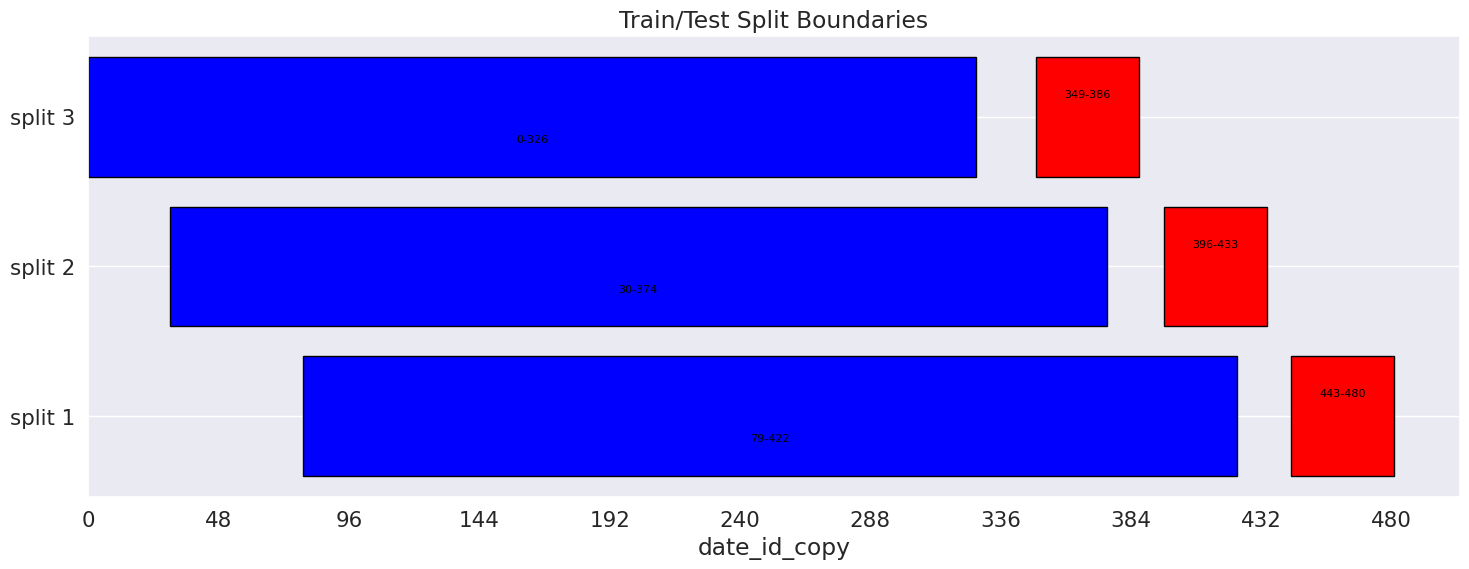

In [47]:
model_pipeline = ModelPipeline()
if config["train_mode"]:
    # 데이터 불러오기
    df = pd.read_csv(f"{config['data_dir']}/train.csv")

    # 데이터 전처리
    data_processor = DataPreprocessor(data=df)
    df = data_processor.transform()

    # 사용할 피쳐 엔지니어링 함수 선택
    feature_engineer = FeatureEngineer(data=df, feature_versions=["feature_version_chan_1"])
    feature_engineer.generate_global_features(data=df)
    df = feature_engineer.transform(save=True) # 맨 처음에는 save=True 돌렸으면, 다음부턴 transform(load=True)로 바꾸면 됨
    
    splitter = Splitter(method=config["split_method"], n_splits=config["n_splits"], correct=config["correct"],
                        initial_fold_size_ratio=config["initial_fold_size_ratio"],
                        train_test_ratio=config["train_test_ratio"], gap=config["gap"])
    for idx, (X_train, y_train, X_test, y_test) in enumerate(splitter.split(data=df)):
        print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
        model_pipeline.train(idx=idx, X_train=X_train, y_train=y_train, X_valid=X_test, y_valid=y_test)
        model_pipeline.predict(idx=idx, X_test=X_test)
        if config["stacking_mode"] and len(config["model_name"]) > 1:  # 각 폴드마다 stacking
            model_pipeline.stacking(idx=idx, y_test=y_test)
    if config["stacking_mode"] and len(config["model_name"]) == 1:  # single model 에 대한 stacking
        model_pipeline.stacking(idx=-1, y_test=y_test,
                                X_test=X_test)  # stacking with last fold. if you want you can stacking with all folds
    model_pipeline.save_models()
    model_pipeline.save_optuna_weights()
    splitter.visualize_splits()

### upload kaggle dataset

#### dataset init
! /home/username/.local/bin/kaggle datasets init -p {config['model_dir']}
#### dataset create 
! /home/username/.local/bin/kaggle datasets create -p {config['model_dir']}

In [39]:
#lgb.plot_importance(model_pipeline.models[0], max_num_features=90, figsize=(10,25))

In [40]:
# KAGGLE_DATASET_NAME = "model-version-31"

In [48]:
if MODE == "train":
    ! /usr/local/bin/kaggle datasets init -p {config['model_dir']}
    import json

    with open(f"{config['model_dir']}/dataset-metadata.json", "r") as file:
        data = json.load(file)

    data["title"] = data["title"].replace("INSERT_TITLE_HERE", f"{KAGGLE_DATASET_NAME}")
    data["id"] = data["id"].replace("INSERT_SLUG_HERE", f"{KAGGLE_DATASET_NAME}")

    with open(f"{config['model_dir']}/dataset-metadata.json", "w") as file:
        json.dump(data, file, indent=2)

    ! /usr/local/bin/kaggle datasets create -p {config['model_dir']}

    # !/usr/local/bin/kaggle datasets version -p {config['model_dir']} -m 'Updated data'

Data package template written to: ./models/20231214_02:48:06/dataset-metadata.json
Starting upload for file 1_lgb.pkl
100%|██████████████████████████████████████| 10.2M/10.2M [00:03<00:00, 3.01MB/s]
Upload successful: 1_lgb.pkl (10MB)
Starting upload for file 2_lgb.pkl
100%|██████████████████████████████████████| 13.6M/13.6M [00:02<00:00, 4.79MB/s]
Upload successful: 2_lgb.pkl (14MB)
Starting upload for file 0_lgb.pkl
100%|██████████████████████████████████████| 11.4M/11.4M [00:03<00:00, 3.94MB/s]
Upload successful: 0_lgb.pkl (11MB)
Your private Dataset is being created. Please check progress at https://www.kaggle.com/datasets/chanlee1012/model-version-chan-100


In [42]:
# if MODE == "train":
#     ! /usr/local/bin/kaggle datasets init -p {chan_DIR1}
#     import json
    
#     with open(f"{chan_DIR1}/dataset-metadata.json", "r") as file:
#         data = json.load(file)

#     data['title'] = data['title'].replace("INSERT_TITLE_HERE", CHAN_GROUP_DATASET_NAME)
#     data['id'] = data['id'].replace("INSERT_SLUG_HERE", CHAN_GROUP_DATASET_NAME)

#     with open(f"{chan_DIR1}/dataset-metadata.json", "w") as file:
#         json.dump(data, file, indent=2)

#     ! /usr/local/bin/kaggle datasets create -p {chan_DIR1}

In [43]:
# if MODE == "train":
#     ! /usr/local/bin/kaggle datasets init -p {chan_DIR2}
#     import json
    
#     with open(f"{chan_DIR2}/dataset-metadata.json", "r") as file:
#         data = json.load(file)

#     data['title'] = data['title'].replace("INSERT_TITLE_HERE", CHAN_REFER_DATASET_NAME)
#     data['id'] = data['id'].replace("INSERT_SLUG_HERE", CHAN_REFER_DATASET_NAME)

#     with open(f"{chan_DIR2}/dataset-metadata.json", "w") as file:
#         json.dump(data, file, indent=2)

#     ! /usr/local/bin/kaggle datasets create -p {chan_DIR2}

In [44]:
# dependencies = {
#     "feature_version_ta_indicators_1": ["feature_version_alvin_1", "feature_version_alvin_2_0"],
#     "feature_version_ta_indicators_2": ["feature_version_alvin_2_0"],
# }

In [49]:
if config["infer_mode"]:
    import optiver2023
    optiver2023.make_env.func_dict['__called__'] = False
    
    env = optiver2023.make_env()
    iter_test = env.iter_test()

    y_min, y_max = -64, 64
    qps = []
    counter = 0
    # cache = pd.DataFrame()

    model_pipeline.load_models()
    model_pipeline.load_optuna_weights()

    # This is for the generate_global_features (only need to run once)
    df = pd.read_csv(f"{config['data_dir']}/train.csv")
    data_processor = DataPreprocessor(data=df)
    df = data_processor.transform()
    feature_engineer = FeatureEngineer(data=df)
    feature_engineer.generate_global_features(data=df)

    for (test, revealed_targets, sample_prediction) in iter_test:
        test['time_id'] = (test['seconds_in_bucket'] / 10) + (test['date_id'] * 55)
        #print(test.columns)
        
        now_time = time.time()
        # cache = pd.concat([cache, test], ignore_index=True, axis=0)
        # if counter > 0:
        #     cache = cache.groupby(['stock_id']).tail(21).sort_values(
        #         by=['date_id', 'seconds_in_bucket', 'stock_id']).reset_index(drop=True)

        # preprocessing
        data_processor = DataPreprocessor(data=test, infer=True)
        test_df = data_processor.transform()

        # feature engineering
        feature_engineer = FeatureEngineer(data=test_df, infer=True,
                                           feature_versions=["feature_version_chan_1"])
        test_df = feature_engineer.transform()
        
        feat = test_df[-len(test):]
        
#         if not test.currently_scored.iloc[0]:
#             sample_prediction['target'] = 0
#             env.predict(sample_prediction)
#             counter += 1
#             qps.append(time.time() - now_time)
#             if counter % 10 == 0:
#                 print(counter, 'qps:', np.mean(qps))
#             continue
            
        feat = feat.drop(columns=["currently_scored"])
        
        # feat = generate_all_features(cache)[-len(test):]
        test_predss = np.zeros(feat.shape[0])
        # prediction
        for i in range(config["n_splits"]):
            model_pipeline.predict(idx=i, X_test=feat)
            if config["stacking_mode"] and len(config["model_name"]) > 1:
                model_pipeline.stacking(idx=i, infer=True)
            test_predss += model_pipeline.inference_prediction / config["n_splits"]
        if config["stacking_mode"] and len(config["model_name"]) == 1:  # single model 에 대한 stacking
            model_pipeline.stacking(idx=-1, infer=True)
            test_predss = model_pipeline.inference_prediction
        test_predss = zero_sum(test_predss, test['bid_size'] + test['ask_size'])
        clipped_predictions = np.clip(test_predss, y_min, y_max)
        sample_prediction['target'] = clipped_predictions

        env.predict(sample_prediction)
        counter += 1
        qps.append(time.time() - now_time)
        if counter % 10 == 0:
            print(counter, 'qps:', np.mean(qps))

    time_cost = 1.146 * np.mean(qps)
    print(f"The code will take approximately {np.round(time_cost, 4)} hours to reason about")

Successfully loaded model (/kaggle/input/model-version-chan-75/0_lgb.pkl)
Successfully loaded model (/kaggle/input/model-version-chan-75/1_lgb.pkl)
Successfully loaded model (/kaggle/input/model-version-chan-75/2_lgb.pkl)

----------------------------------------------------------------------------------------------------
Executed handle_missing_data, Elapsed time: 3.33 seconds, shape((5237760, 17))
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
Executed transform, Elapsed time: 3.33 seconds, shape((5237760, 17))
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
Executed generate_global_features, Elapsed time: 1.41 seconds
----------------------------------------------------------

ValueError: Number of features of the model must match the input. Model n_features_ is 65 and input n_features is 21

In [45]:
# if config["infer_mode"]:
#     import optiver2023
#     optiver2023.make_env.func_dict['__called__'] = False
#     env = optiver2023.make_env()
#     iter_test = env.iter_test()

    # y_min, y_max = -64, 64
    # qps = []
    # counter = 0
    # cache = pd.DataFrame()

    # model_pipeline.load_models()
    # model_pipeline.load_optuna_weights()

    # # This is for the generate_global_features (only need to run once)
    # df = pd.read_csv(f"{config['data_dir']}/train.csv")
    # data_processor = DataPreprocessor(data=df)
    # df = data_processor.transform()
    # feature_engineer = FeatureEngineer(data=df)
    # feature_engineer.generate_global_features(data=df)

    # for (test, revealed_targets, sample_prediction) in iter_test:
    #     test['time_id'] = (test['seconds_in_bucket'] / 10) + (test['date_id'] * 55)
    #     now_time = time.time()
    #     cache = pd.concat([cache, test], ignore_index=True, axis=0)
    #     if counter > 0:
    #         cache = cache.groupby(['stock_id']).tail(21).sort_values(
    #             by=['date_id', 'seconds_in_bucket', 'stock_id']).reset_index(drop=True)

    #     # preprocessing
    #     data_processor = DataPreprocessor(data=cache, infer=True)
    #     cache_df = data_processor.transform()

    #     # feature engineering
    #     feature_engineer = FeatureEngineer(data=cache_df, infer=True,
    #                                        feature_versions=['feature_version_chan_1'])
    #     cache_df = feature_engineer.transform()

    #     feat = cache_df[-len(test):]
    #     if not test.currently_scored.iloc[0]:
    #         sample_prediction['target'] = 0
    #         env.predict(sample_prediction)
    #         counter += 1
    #         qps.append(time.time() - now_time)
    #         if counter % 10 == 0:
    #             print(counter, 'qps:', np.mean(qps))
    #         continue
    #     feat = feat.drop(columns=["currently_scored"])

    #     # feat = generate_all_features(cache)[-len(test):]
    #     test_predss = np.zeros(feat.shape[0])
    #     # prediction
    #     for i in range(config["n_splits"]):
    #         model_pipeline.predict(idx=i, X_test=feat)
    #         if config["stacking_mode"] and len(config["model_name"]) > 1:
    #             model_pipeline.stacking(idx=i, infer=True)
    #         test_predss += model_pipeline.inference_prediction / config["n_splits"]
    #     if config["stacking_mode"] and len(config["model_name"]) == 1:  # single model 에 대한 stacking
    #         model_pipeline.stacking(idx=-1, infer=True)
    #         test_predss = model_pipeline.inference_prediction
    #     test_predss = zero_sum(test_predss, test['bid_size'] + test['ask_size'])
    #     clipped_predictions = np.clip(test_predss, y_min, y_max)
    #     sample_prediction['target'] = clipped_predictions
    #     env.predict(sample_prediction)
    #     counter += 1
    #     qps.append(time.time() - now_time)
    #     if counter % 10 == 0:
    #         print(counter, 'qps:', np.mean(qps))

    # time_cost = 1.146 * np.mean(qps)
    # print(f"The code will take approximately {np.round(time_cost, 4)} hours to reason about")

In [ ]:
# single 1fold final / fianl no
# single 1fold final / fianl
# single 5fold final / fianl no
# single 5fold final / fianl
# stacking 1fold final / fianl no
# stacking 1fold final / fianl
# stacking 5fold final / fianl no
# stacking 5fold final / fianl